The consultation was carried out in the Seismicity Catalogue of the Servicio Geológico Colombiano: http://bdrsnc.sgc.gov.co/paginas1/catalogo/index.php

| | Mínimo | Máximo |
|--------|-------|------|
| Longitud | -73.4 | -72.8 |
| Latitud | 6.5 | 7.1 |
| X 3116 | 1074939.954 | 1141139.675 |
| Y 3116 | 1210581.371 | 1277079.632 |
| Año | 1994 | 2024 (feb.) |

*From 2024 only until February 29 was considered.*

---
ML References:
- Ridzwan, N. S. M., & Yusoff, S. H. Md. (2023). Machine learning for earthquake prediction: a review (2017–2021). In Earth Science Informatics (Vol. 16, Issue 2, pp. 1133–1149). Springer Science and Business Media LLC. https://doi.org/10.1007/s12145-023-00991-z

---
References Gutenberg-Richter Law:
- Gutenberg, B., & Richter, C. F. (1944). Frequency of earthquakes in California*. In Bulletin of the Seismological Society of America (Vol. 34, Issue 4, pp. 185–188). Seismological Society of America (SSA). https://doi.org/10.1785/bssa0340040185
- Pailoplee, S., & Choowong, M. (2014). Earthquake frequency-magnitude distribution and fractal dimension in mainland Southeast Asia. In Earth, Planets and Space (Vol. 66, Issue 1, p. 8). Springer Science and Business Media LLC. https://doi.org/10.1186/1880-5981-66-8
- Sianturi, H. L., Susilo, A., Sunaryo, & Maryanto, S. (2019). Correlation Analysis of Spatial Distribution, Temporal Seismotectonics, and Return Period of Earthquake in East Nusa Tenggara, Indonesia. In International Journal of Geophysics (Vol. 2019, pp. 1–11). Hindawi Limited. https://doi.org/10.1155/2019/5485783

---




# New considerations
- It will be maintained that the earthquakes are of magnitudes greater than or equal to 2.5 since from that magnitude the catalog seems to be complete.
- Evaluate how to consider from the cumulative point of the number of events from 100 km to ensure that they are nest events.
- Include an analysis of the location errors in km of the events both in X, Y, but mainly in depth.
- Perform the analysis of the Gutenberg-Richter law. Histograms of all events and calculation of a and b value. Estimate the recurrence periods for events of magnitudes greater than 4.5.
- For training, the period from 1994 to 2021 will be considered. And from 2022 to 2024 the models will be evaluated.
- Define why 30 days? To do this, consider the Gutenberg-Richter law and the recurrence period. Consider a possible time range to emerge from these results.
- Consider every 6 months (180 days) 1 year (365 days).
- Generate about 3-4 models for each new consideration.



# Start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 24.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import contextily as cx #para el basemap en geopandas
import xyzservices.providers as xyz #para escoger el basemap
import time

from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Para evaluar el modelo
from sklearn.neural_network import MLPClassifier # Para la Red Neuronal
from joblib import dump, load # guardar el modelo
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression # Para generar el Modelo de Reg. Lineal

# Load data

In [ ]:
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/'

df = pd.read_csv(pathDatos+'df_Total_1994_2024.csv')
df['Date-Time'] = pd.to_datetime(df['Date-Time'], yearfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148986 entries, 0 to 148985
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   148986 non-null  object        
 1   HORA_UTC                148986 non-null  object        
 2   LATITUD (grados)        148986 non-null  float64       
 3   LONGITUD (grados)       148986 non-null  float64       
 4   PROFUNDIDAD (Km)        148986 non-null  float64       
 5   MAGNITUD Ml             148986 non-null  float64       
 6   ERROR LATITUD (Km)      148910 non-null  float64       
 7   ERROR LONGITUD (Km)     148910 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  148910 non-null  float64       
 9   Date-Time               148986 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 11.4+ MB


In [ ]:
df.describe().round(2)

,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),Date-Time
count,148986.00,148986.00,148986.00,148986.00,148910.00,148910.00,148910.00,148986
mean,6.80,-73.13,143.26,2.05,4.63,6.88,7.08,2014-04-05 20:58:52.822003200
min,6.50,-73.40,-4.88,0.10,0.00,0.00,0.00,1994-01-01 00:06:37
25%,6.77,-73.17,140.00,1.60,2.62,3.10,4.20,2009-12-21 02:16:42.500000
50%,6.80,-73.14,144.60,1.90,4.10,5.17,6.50,2016-01-08 00:29:42.500000
75%,6.82,-73.10,148.50,2.40,5.80,8.70,8.85,2020-05-23 18:21:52.500000
max,7.10,-72.80,436.50,6.30,99.90,99.90,99.90,2024-02-29 23:17:12
std,0.05,0.08,12.08,0.62,3.25,6.16,4.97,NaN


In [ ]:
df.isnull().sum()

FECHA                      0
HORA_UTC                   0
LATITUD (grados)           0
LONGITUD (grados)          0
PROFUNDIDAD (Km)           0
MAGNITUD Ml                0
ERROR LATITUD (Km)        76
ERROR LONGITUD (Km)       76
ERROR PROFUNDIDAD (Km)    76
Date-Time                  0
dtype: int64

There are 76 events that have no values ​​in the error. Therefore, they will be deleted.

In [ ]:
df_Filtrado = df.dropna().copy()
df_Filtrado.reset_index(drop=True, inplace=True)
df_Filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148910 entries, 0 to 148909
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   148910 non-null  object        
 1   HORA_UTC                148910 non-null  object        
 2   LATITUD (grados)        148910 non-null  float64       
 3   LONGITUD (grados)       148910 non-null  float64       
 4   PROFUNDIDAD (Km)        148910 non-null  float64       
 5   MAGNITUD Ml             148910 non-null  float64       
 6   ERROR LATITUD (Km)      148910 non-null  float64       
 7   ERROR LONGITUD (Km)     148910 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  148910 non-null  float64       
 9   Date-Time               148910 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 11.4+ MB


## Histograms

### The entire catalog

In [ ]:
df_Filtrado.columns

Index(['FECHA', 'HORA_UTC', 'LATITUD (grados)', 'LONGITUD (grados)',
       'PROFUNDIDAD (Km)', 'MAGNITUD Ml', 'ERROR LATITUD (Km)',
       'ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)', 'Date-Time'],
      dtype='object')

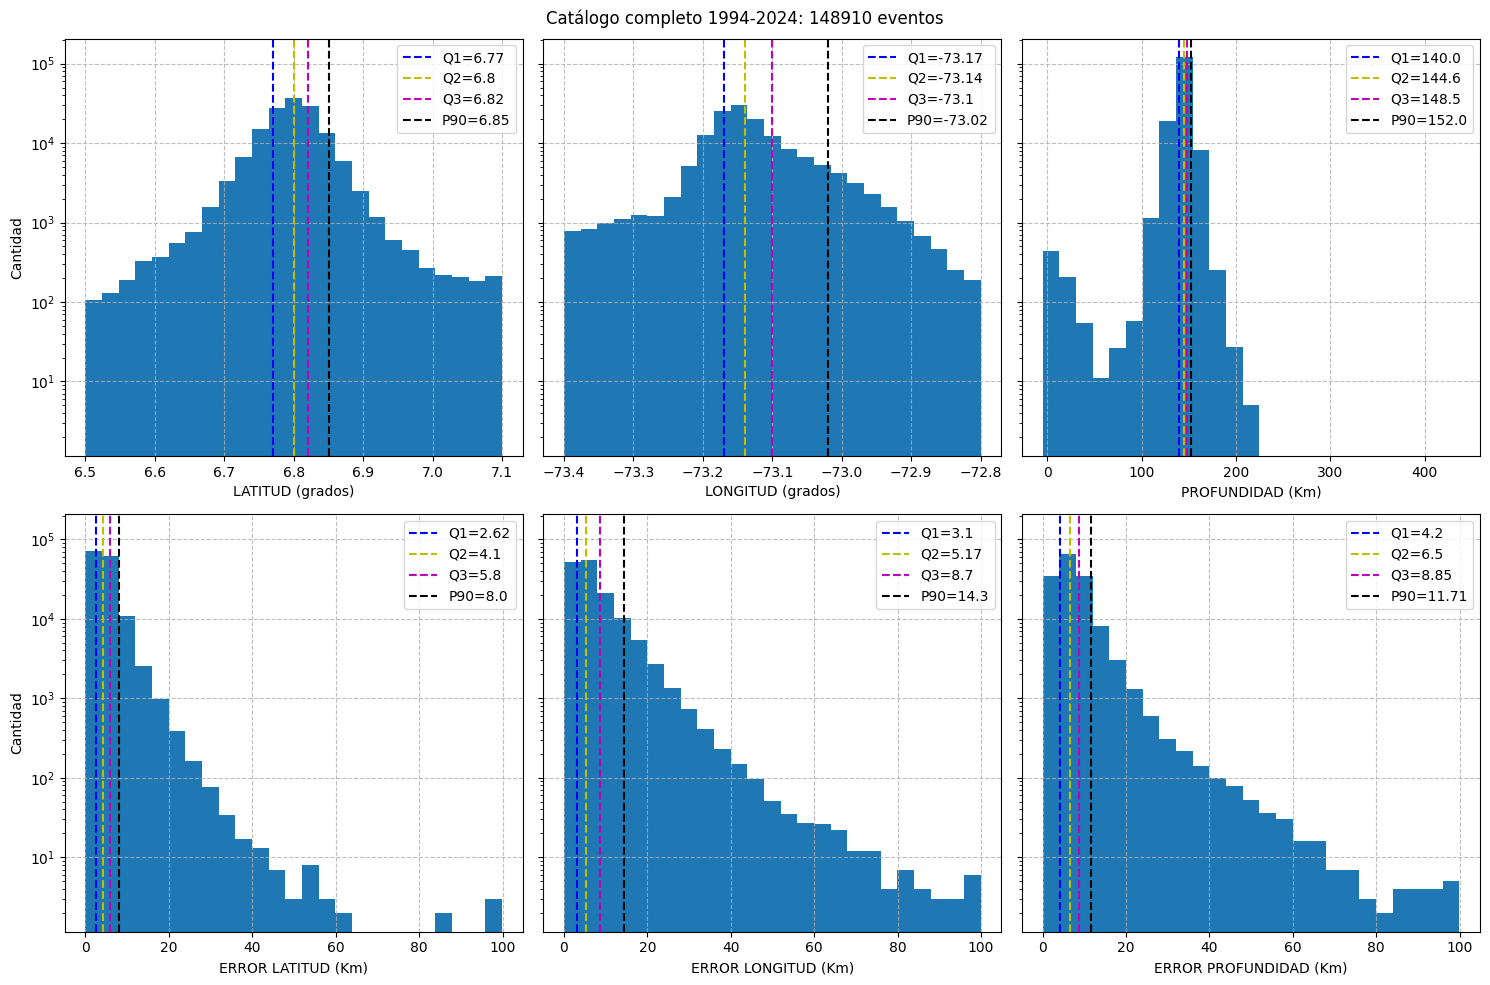

In [ ]:
columnas = ['LATITUD (grados)', 'LONGITUD (grados)', 'PROFUNDIDAD (Km)',
            'ERROR LATITUD (Km)','ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True, tight_layout=True)
for i in range(len(columnas)):
  Q1 = np.round(df_Filtrado[columnas[i]].quantile(0.25), 2)
  Q2 = np.round(df_Filtrado[columnas[i]].quantile(0.5), 2)
  Q3 = np.round(df_Filtrado[columnas[i]].quantile(0.75), 2)
  P90 = np.round(df_Filtrado[columnas[i]].quantile(0.90), 2)

  if i < 3:
    axs[0, i].hist(df_Filtrado[columnas[i]], bins=25)
    axs[0, i].axvline(x= Q1,
                      ls='--',
                      color='b',
                      label='Q1={}'.format(Q1))
    axs[0, i].axvline(x= Q2,
                      ls='--',
                      color='y',
                      label='Q2={}'.format(Q2))
    axs[0, i].axvline(x= Q3,
                      ls='--',
                      color='m',
                      label='Q3={}'.format(Q3))
    axs[0, i].axvline(x= P90,
                      ls='--',
                      color='k',
                      label='P90={}'.format(P90))

    axs[0, i].legend()
    axs[0, i].set_yscale('log')

    axs[0, i].grid(ls='--', alpha=0.8)
    axs[0, i].set_xlabel(columnas[i])
  else:
    axs[1, i-3].hist(df_Filtrado[columnas[i]], bins=25)
    axs[1, i-3].axvline(x= Q1,
                        ls='--',
                        color='b',
                        label='Q1={}'.format(Q1))
    axs[1, i-3].axvline(x= Q2,
                        ls='--',
                        color='y',
                        label='Q2={}'.format(Q2))
    axs[1, i-3].axvline(x= Q3,
                        ls='--',
                        color='m',
                        label='Q3={}'.format(Q3))
    axs[1, i-3].axvline(x= P90,
                        ls='--',
                        color='k',
                        label='P90={}'.format(P90))
    axs[1, i-3].legend()
    axs[1, i-3].set_yscale('log')

    axs[1, i-3].grid(ls='--', alpha=0.8)
    axs[1, i-3].set_xlabel(columnas[i])

axs[0,0].set_ylabel('Cantidad')
axs[1,0].set_ylabel('Cantidad')
plt.suptitle('Catálogo completo 1994-2024: {} eventos'.format(len(df_Filtrado)))

plt.savefig((pathSaveFiguras + 'histEventos_1994_2024.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

### Depth >= 50 km

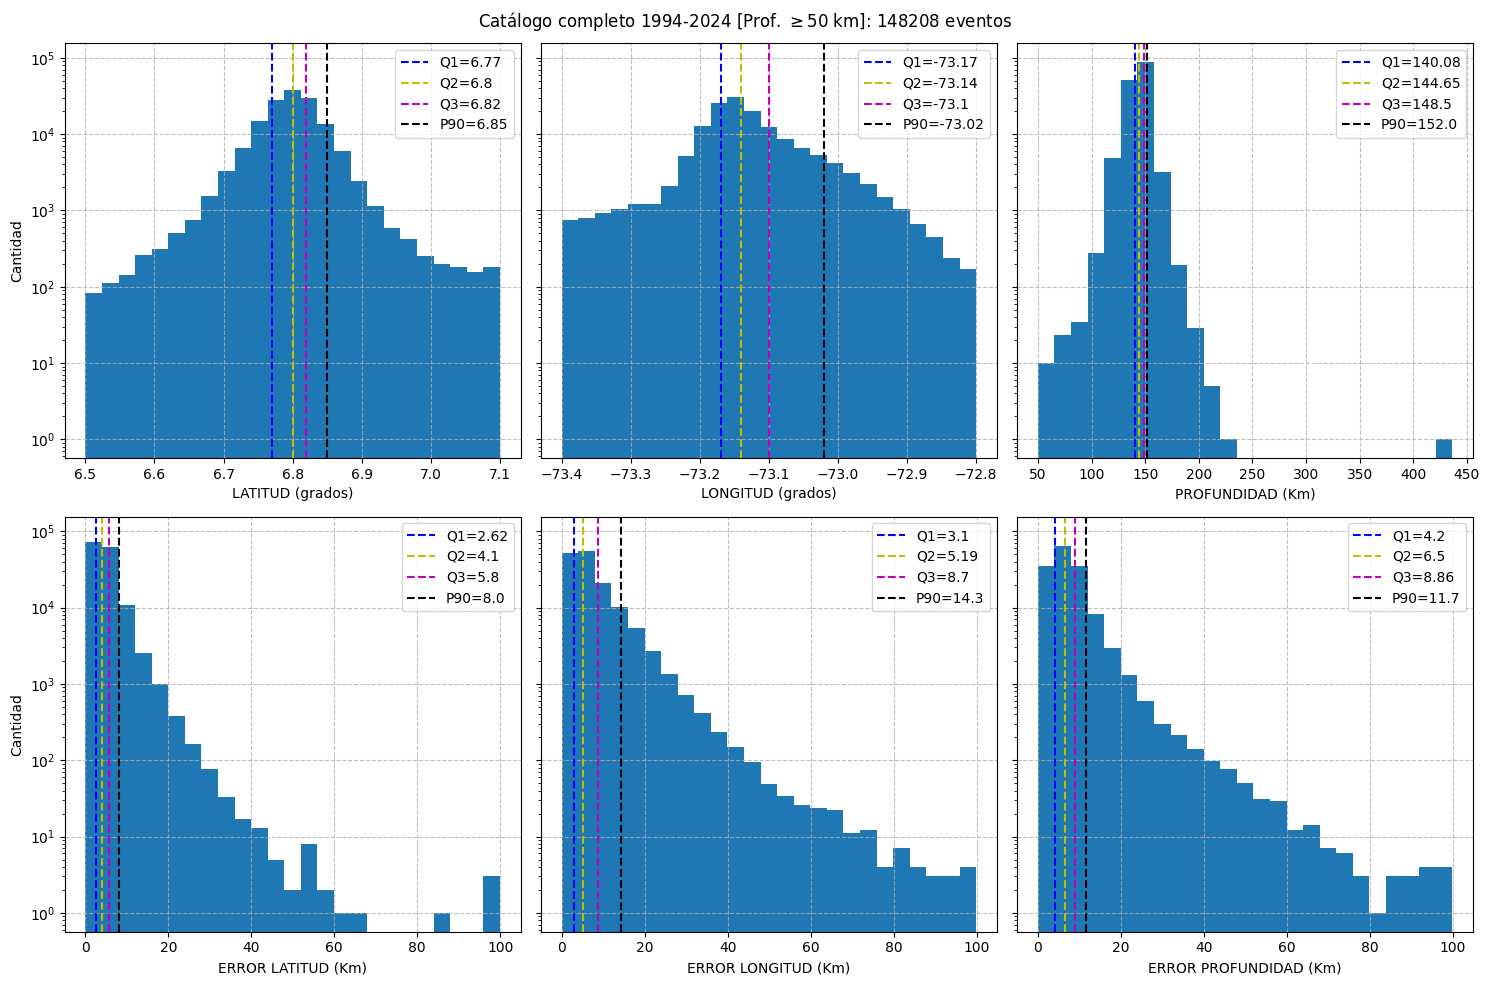

In [ ]:
columnas = ['LATITUD (grados)', 'LONGITUD (grados)', 'PROFUNDIDAD (Km)',
            'ERROR LATITUD (Km)','ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)']

df_Filtrado_50km = df_Filtrado[df_Filtrado['PROFUNDIDAD (Km)'] >= 50]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True, tight_layout=True)
for i in range(len(columnas)):
  Q1 = np.round(df_Filtrado_50km[columnas[i]].quantile(0.25), 2)
  Q2 = np.round(df_Filtrado_50km[columnas[i]].quantile(0.5), 2)
  Q3 = np.round(df_Filtrado_50km[columnas[i]].quantile(0.75), 2)
  P90 = np.round(df_Filtrado_50km[columnas[i]].quantile(0.90), 2)

  if i < 3:
    axs[0, i].hist(df_Filtrado_50km[columnas[i]], bins=25)
    axs[0, i].axvline(x= Q1,
                      ls='--',
                      color='b',
                      label='Q1={}'.format(Q1))
    axs[0, i].axvline(x= Q2,
                      ls='--',
                      color='y',
                      label='Q2={}'.format(Q2))
    axs[0, i].axvline(x= Q3,
                      ls='--',
                      color='m',
                      label='Q3={}'.format(Q3))
    axs[0, i].axvline(x= P90,
                      ls='--',
                      color='k',
                      label='P90={}'.format(P90))

    axs[0, i].legend()
    axs[0, i].set_yscale('log')

    axs[0, i].grid(ls='--', alpha=0.8)
    axs[0, i].set_xlabel(columnas[i])
  else:
    axs[1, i-3].hist(df_Filtrado_50km[columnas[i]], bins=25)
    axs[1, i-3].axvline(x= Q1,
                        ls='--',
                        color='b',
                        label='Q1={}'.format(Q1))
    axs[1, i-3].axvline(x= Q2,
                        ls='--',
                        color='y',
                        label='Q2={}'.format(Q2))
    axs[1, i-3].axvline(x= Q3,
                        ls='--',
                        color='m',
                        label='Q3={}'.format(Q3))
    axs[1, i-3].axvline(x= P90,
                        ls='--',
                        color='k',
                        label='P90={}'.format(P90))
    axs[1, i-3].legend()
    axs[1, i-3].set_yscale('log')

    axs[1, i-3].grid(ls='--', alpha=0.8)
    axs[1, i-3].set_xlabel(columnas[i])

axs[0,0].set_ylabel('Cantidad')
axs[1,0].set_ylabel('Cantidad')
plt.suptitle('Catálogo completo 1994-2024 [Prof. $\geq 50$ km]: {} eventos'.format(len(df_Filtrado_50km)))

plt.savefig((pathSaveFiguras + 'histEventos_1994_2024_50km.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

### Depth >= 100 km

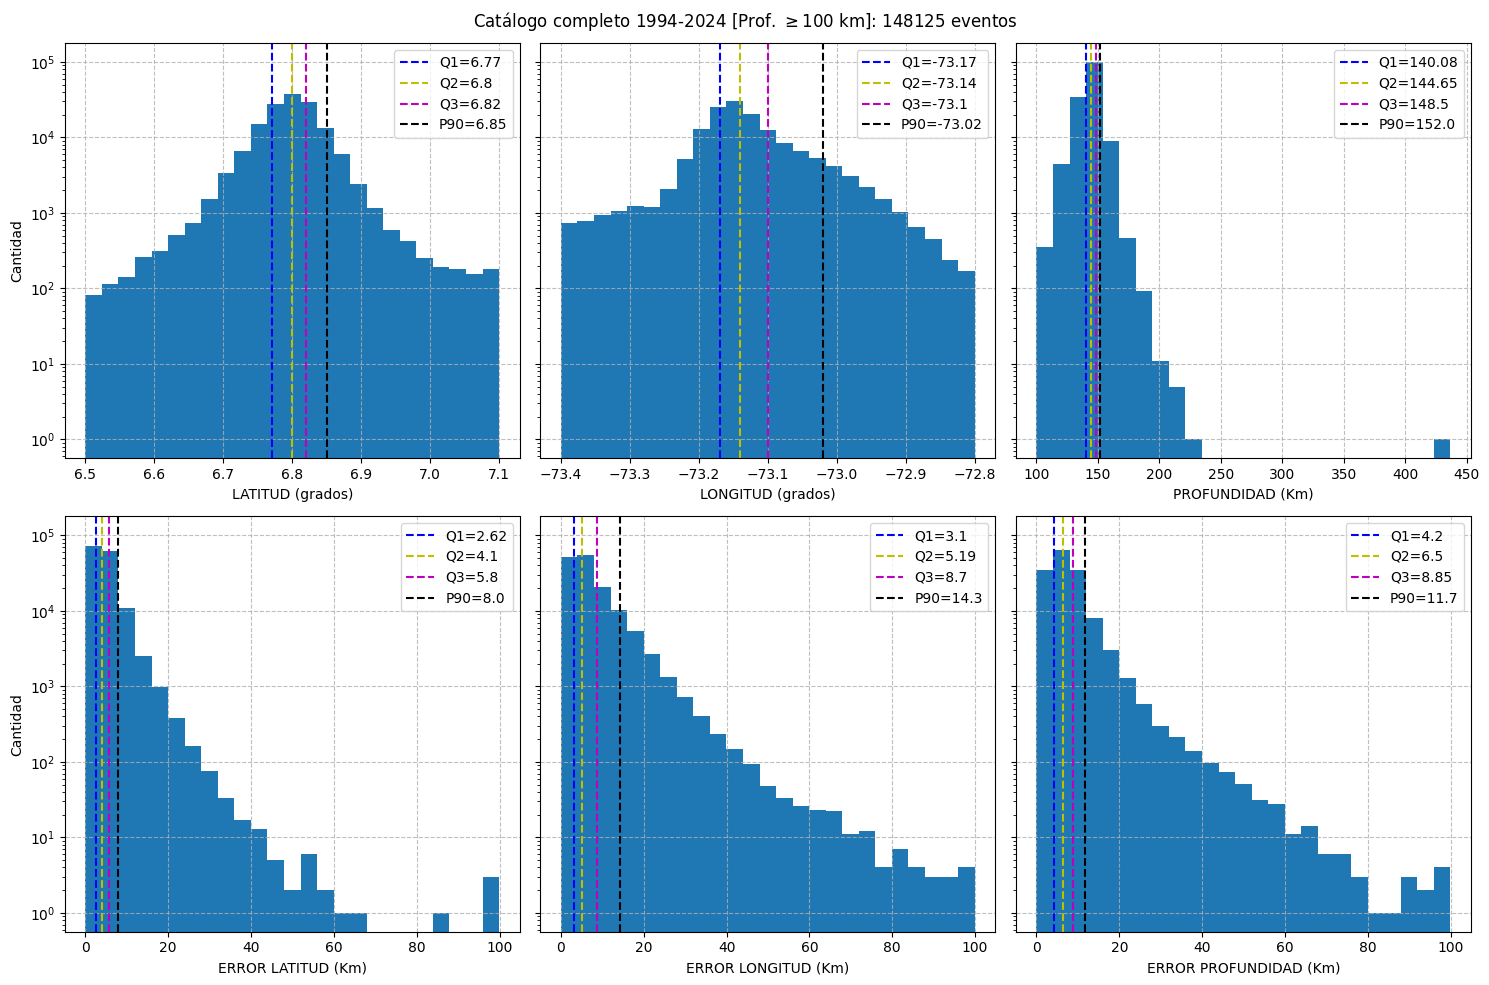

In [ ]:
columnas = ['LATITUD (grados)', 'LONGITUD (grados)', 'PROFUNDIDAD (Km)',
            'ERROR LATITUD (Km)','ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)']

df_Filtrado_100km = df_Filtrado[df_Filtrado['PROFUNDIDAD (Km)'] >= 100]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True, tight_layout=True)
for i in range(len(columnas)):
  Q1 = np.round(df_Filtrado_100km[columnas[i]].quantile(0.25), 2)
  Q2 = np.round(df_Filtrado_100km[columnas[i]].quantile(0.5), 2)
  Q3 = np.round(df_Filtrado_100km[columnas[i]].quantile(0.75), 2)
  P90 = np.round(df_Filtrado_100km[columnas[i]].quantile(0.90), 2)

  if i < 3:
    axs[0, i].hist(df_Filtrado_100km[columnas[i]], bins=25)
    axs[0, i].axvline(x= Q1,
                      ls='--',
                      color='b',
                      label='Q1={}'.format(Q1))
    axs[0, i].axvline(x= Q2,
                      ls='--',
                      color='y',
                      label='Q2={}'.format(Q2))
    axs[0, i].axvline(x= Q3,
                      ls='--',
                      color='m',
                      label='Q3={}'.format(Q3))
    axs[0, i].axvline(x= P90,
                      ls='--',
                      color='k',
                      label='P90={}'.format(P90))

    axs[0, i].legend()
    axs[0, i].set_yscale('log')

    axs[0, i].grid(ls='--', alpha=0.8)
    axs[0, i].set_xlabel(columnas[i])
  else:
    axs[1, i-3].hist(df_Filtrado_100km[columnas[i]], bins=25)
    axs[1, i-3].axvline(x= Q1,
                        ls='--',
                        color='b',
                        label='Q1={}'.format(Q1))
    axs[1, i-3].axvline(x= Q2,
                        ls='--',
                        color='y',
                        label='Q2={}'.format(Q2))
    axs[1, i-3].axvline(x= Q3,
                        ls='--',
                        color='m',
                        label='Q3={}'.format(Q3))
    axs[1, i-3].axvline(x= P90,
                        ls='--',
                        color='k',
                        label='P90={}'.format(P90))
    axs[1, i-3].legend()
    axs[1, i-3].set_yscale('log')

    axs[1, i-3].grid(ls='--', alpha=0.8)
    axs[1, i-3].set_xlabel(columnas[i])

axs[0,0].set_ylabel('Cantidad')
axs[1,0].set_ylabel('Cantidad')
plt.suptitle('Catálogo completo 1994-2024 [Prof. $\geq 100$ km]: {} eventos'.format(len(df_Filtrado_100km)))

plt.savefig((pathSaveFiguras + 'histEventos_1994_2024_100km.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

### Magnitudes

In [ ]:
df_Filtrado.columns

Index(['FECHA', 'HORA_UTC', 'LATITUD (grados)', 'LONGITUD (grados)',
       'PROFUNDIDAD (Km)', 'MAGNITUD Ml', 'ERROR LATITUD (Km)',
       'ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)', 'Date-Time'],
      dtype='object')

In [ ]:
for datos in [df_Filtrado, df_Filtrado_50km, df_Filtrado_100km]:
  print(len(datos))

148910
148208
148125


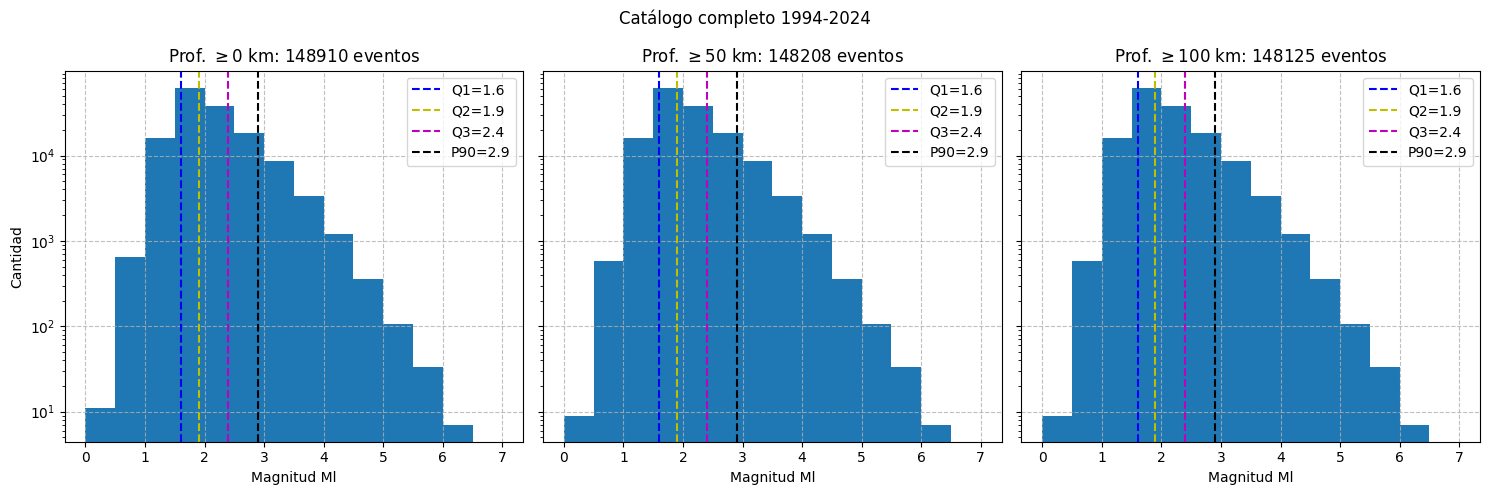

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5),
                        sharey=True,
                        sharex=True,
                        tight_layout=True)

idx = 0
profTitulo = [0, 50, 100]

for datos in [df_Filtrado, df_Filtrado_50km, df_Filtrado_100km]:
  Q1 = np.round(datos['MAGNITUD Ml'].quantile(0.25), 2)
  Q2 = np.round(datos['MAGNITUD Ml'].quantile(0.5), 2)
  Q3 = np.round(datos['MAGNITUD Ml'].quantile(0.75), 2)
  P90 = np.round(datos['MAGNITUD Ml'].quantile(0.90), 2)

  axs[idx].hist(datos['MAGNITUD Ml'], bins=14, range=(0,7))
  axs[idx].axvline(x= Q1,
                    ls='--',
                    color='b',
                    label='Q1={}'.format(Q1))
  axs[idx].axvline(x= Q2,
                    ls='--',
                    color='y',
                    label='Q2={}'.format(Q2))
  axs[idx].axvline(x= Q3,
                    ls='--',
                    color='m',
                    label='Q3={}'.format(Q3))
  axs[idx].axvline(x= P90,
                    ls='--',
                    color='k',
                    label='P90={}'.format(P90))

  axs[idx].legend()
  axs[idx].set_yscale('log')

  axs[idx].grid(ls='--', alpha=0.8)
  axs[idx].set_xlabel('Magnitud Ml')
  axs[idx].set_title('Prof. $\geq {}$ km: {} eventos'.format(profTitulo[idx] ,len(datos)))

  idx += 1

axs[0].set_ylabel('Cantidad')


plt.suptitle('Catálogo completo 1994-2024')

plt.savefig((pathSaveFiguras + 'histEventos_1994_2024_magnitudes.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

In [ ]:
print(len(df_Filtrado))
print(len(df_Filtrado_50km))
print(len(df_Filtrado_100km))

148910
148208
148125


- The complete catalogue has 148910 events.
- At depths $\geq 50$ km there are 148208 events.
- At depths $\geq 100$ km there are 148125 events.
- Considering the 90th percentile (P90) values ​​of the errors for Latitude, Longitude and Depth in kilometers, only events with errors less than 10 km will be considered.



### Error filtering <= 10 km

In [ ]:
df_Filtrado.columns

Index(['FECHA', 'HORA_UTC', 'LATITUD (grados)', 'LONGITUD (grados)',
       'PROFUNDIDAD (Km)', 'MAGNITUD Ml', 'ERROR LATITUD (Km)',
       'ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)', 'Date-Time'],
      dtype='object')

In [ ]:
df_Filtrado_err10km = (df_Filtrado['ERROR LATITUD (Km)'] <= 10) & (df_Filtrado['ERROR LONGITUD (Km)'] <= 10) & (df_Filtrado['ERROR PROFUNDIDAD (Km)'] <= 10)
df_Filtrado_err10km = df_Filtrado[df_Filtrado_err10km].copy()
df_Filtrado_err10km.reset_index(drop=True, inplace=True)

df_Filtrado_err10km

,FECHA,HORA_UTC,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),Date-Time
0,1994-01-03,14:23:38,6.783,-73.049,150.00,3.2,4.900,4.800,6.70,1994-01-03 14:23:38
1,1994-01-05,16:13:03,6.777,-73.206,145.00,3.0,6.200,5.800,8.80,1994-01-05 16:13:03
2,1994-01-19,10:49:56,6.803,-73.058,145.00,2.7,7.700,7.500,8.70,1994-01-19 10:49:56
3,1994-02-01,12:22:41,6.855,-73.030,150.00,3.2,7.800,7.800,9.00,1994-02-01 12:22:41
4,1994-02-18,21:51:09,6.831,-73.176,146.00,2.7,7.500,7.200,8.80,1994-02-18 21:51:09
...,...,...,...,...,...,...,...,...,...,...
112915,2024-02-29,17:14:57,6.763,-73.115,151.41,1.9,2.333,2.333,3.30,2024-02-29 17:14:57
112916,2024-02-29,19:34:58,6.783,-73.103,133.05,2.1,5.340,6.709,6.36,2024-02-29 19:34:58
112917,2024-02-29,21:21:08,6.809,-73.092,149.00,1.9,3.536,3.536,2.30,2024-02-29 21:21:08
112918,2024-02-29,22:13:41,6.769,-73.076,146.99,2.9,1.851,3.142,4.15,2024-02-29 22:13:41


#### The entire catalog

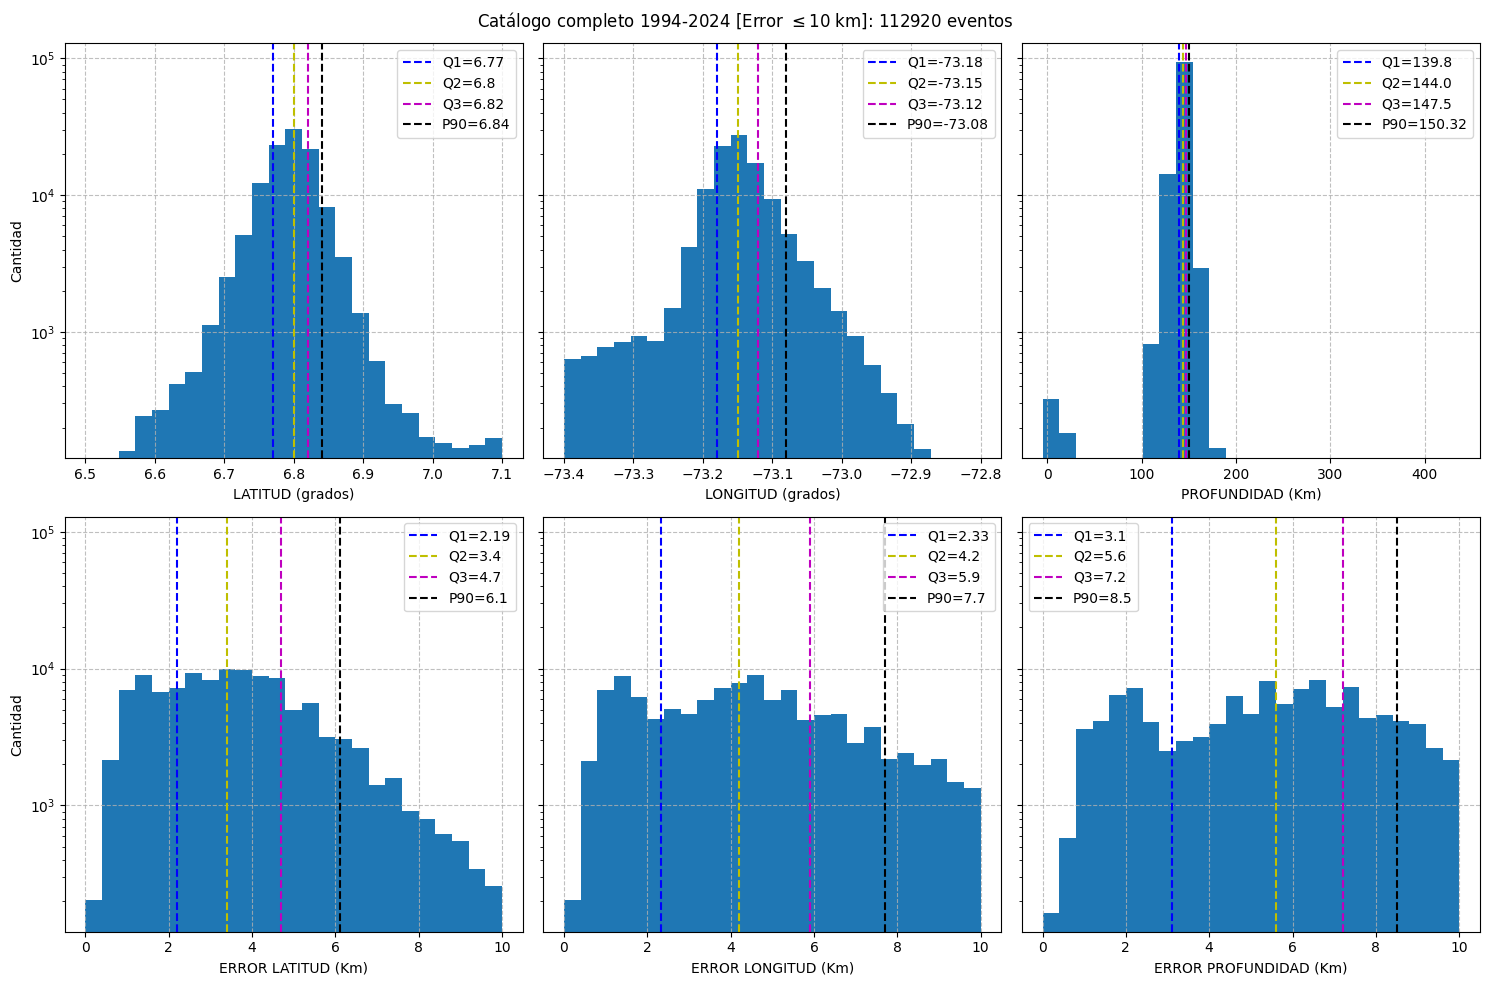

In [ ]:
columnas = ['LATITUD (grados)', 'LONGITUD (grados)', 'PROFUNDIDAD (Km)',
            'ERROR LATITUD (Km)','ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True, tight_layout=True)
for i in range(len(columnas)):
  Q1 = np.round(df_Filtrado_err10km[columnas[i]].quantile(0.25), 2)
  Q2 = np.round(df_Filtrado_err10km[columnas[i]].quantile(0.5), 2)
  Q3 = np.round(df_Filtrado_err10km[columnas[i]].quantile(0.75), 2)
  P90 = np.round(df_Filtrado_err10km[columnas[i]].quantile(0.90), 2)

  if i < 3:
    axs[0, i].hist(df_Filtrado_err10km[columnas[i]], bins=25)
    axs[0, i].axvline(x= Q1,
                      ls='--',
                      color='b',
                      label='Q1={}'.format(Q1))
    axs[0, i].axvline(x= Q2,
                      ls='--',
                      color='y',
                      label='Q2={}'.format(Q2))
    axs[0, i].axvline(x= Q3,
                      ls='--',
                      color='m',
                      label='Q3={}'.format(Q3))
    axs[0, i].axvline(x= P90,
                      ls='--',
                      color='k',
                      label='P90={}'.format(P90))

    axs[0, i].legend()
    axs[0, i].set_yscale('log')

    axs[0, i].grid(ls='--', alpha=0.8)
    axs[0, i].set_xlabel(columnas[i])
  else:
    axs[1, i-3].hist(df_Filtrado_err10km[columnas[i]], bins=25)
    axs[1, i-3].axvline(x= Q1,
                        ls='--',
                        color='b',
                        label='Q1={}'.format(Q1))
    axs[1, i-3].axvline(x= Q2,
                        ls='--',
                        color='y',
                        label='Q2={}'.format(Q2))
    axs[1, i-3].axvline(x= Q3,
                        ls='--',
                        color='m',
                        label='Q3={}'.format(Q3))
    axs[1, i-3].axvline(x= P90,
                        ls='--',
                        color='k',
                        label='P90={}'.format(P90))
    axs[1, i-3].legend()
    axs[1, i-3].set_yscale('log')

    axs[1, i-3].grid(ls='--', alpha=0.8)
    axs[1, i-3].set_xlabel(columnas[i])

axs[0,0].set_ylabel('Cantidad')
axs[1,0].set_ylabel('Cantidad')
plt.suptitle('Catálogo completo 1994-2024 [Error $\leq 10$ km]: {} eventos'.format(len(df_Filtrado_err10km)))

plt.savefig((pathSaveFiguras + 'histEventos_1994_2024_err10km.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

#### Depth >= 50 km

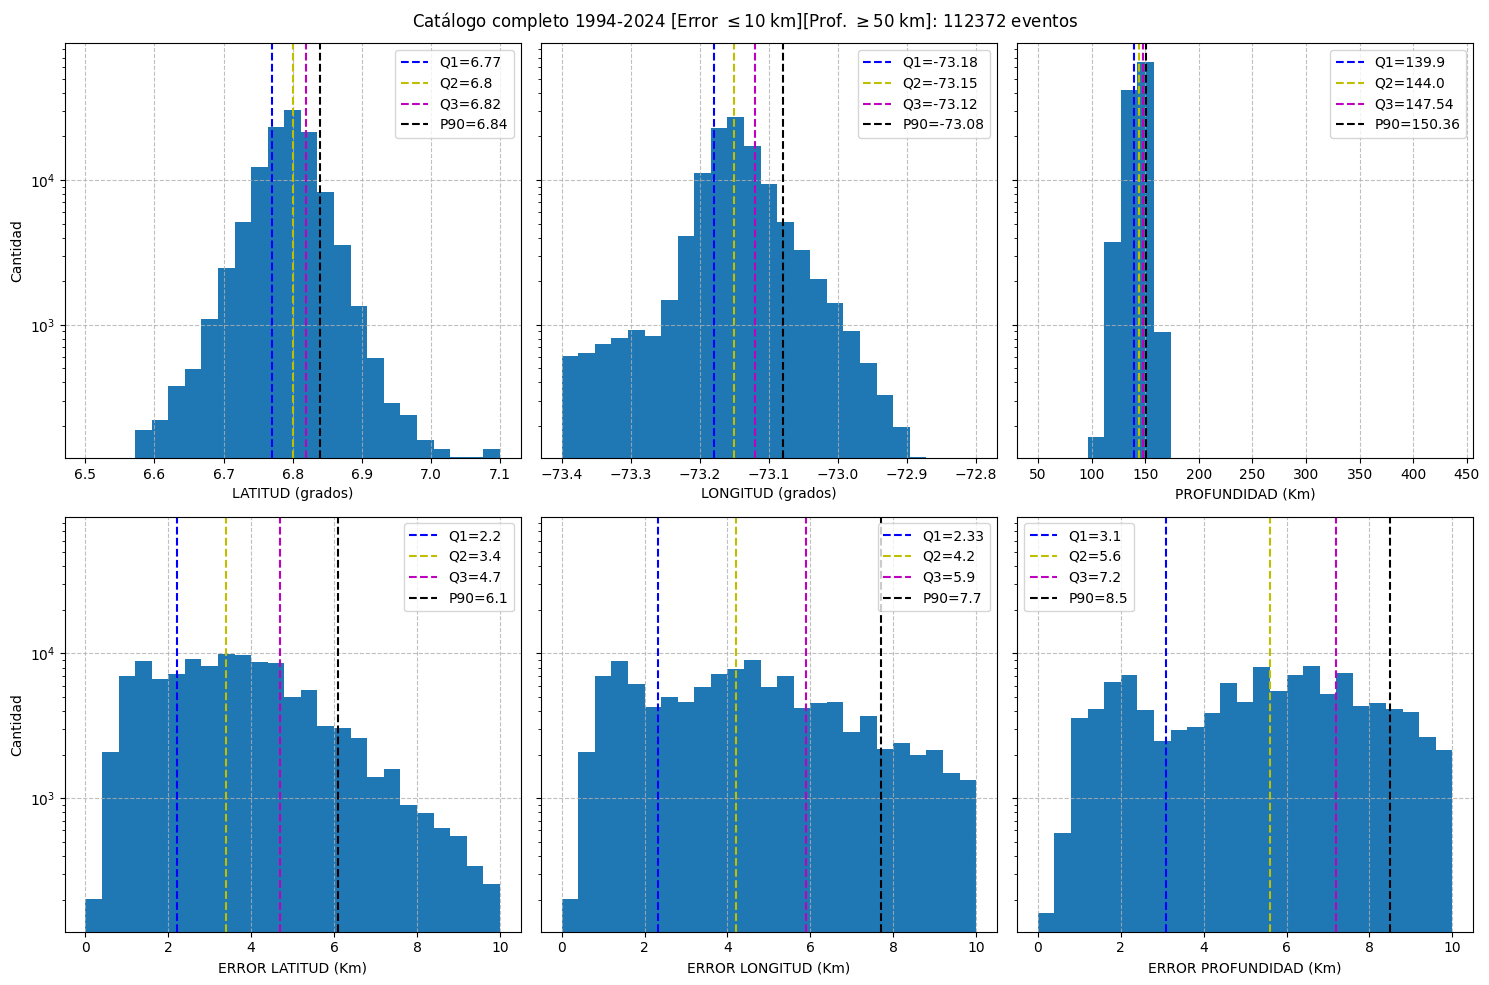

In [ ]:
columnas = ['LATITUD (grados)', 'LONGITUD (grados)', 'PROFUNDIDAD (Km)',
            'ERROR LATITUD (Km)','ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)']

df_Filtrado_err10km_50km = df_Filtrado_err10km[df_Filtrado_err10km['PROFUNDIDAD (Km)'] >= 50]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True, tight_layout=True)
for i in range(len(columnas)):
  Q1 = np.round(df_Filtrado_err10km_50km[columnas[i]].quantile(0.25), 2)
  Q2 = np.round(df_Filtrado_err10km_50km[columnas[i]].quantile(0.5), 2)
  Q3 = np.round(df_Filtrado_err10km_50km[columnas[i]].quantile(0.75), 2)
  P90 = np.round(df_Filtrado_err10km_50km[columnas[i]].quantile(0.90), 2)

  if i < 3:
    axs[0, i].hist(df_Filtrado_err10km_50km[columnas[i]], bins=25)
    axs[0, i].axvline(x= Q1,
                      ls='--',
                      color='b',
                      label='Q1={}'.format(Q1))
    axs[0, i].axvline(x= Q2,
                      ls='--',
                      color='y',
                      label='Q2={}'.format(Q2))
    axs[0, i].axvline(x= Q3,
                      ls='--',
                      color='m',
                      label='Q3={}'.format(Q3))
    axs[0, i].axvline(x= P90,
                      ls='--',
                      color='k',
                      label='P90={}'.format(P90))

    axs[0, i].legend()
    axs[0, i].set_yscale('log')

    axs[0, i].grid(ls='--', alpha=0.8)
    axs[0, i].set_xlabel(columnas[i])
  else:
    axs[1, i-3].hist(df_Filtrado_err10km_50km[columnas[i]], bins=25)
    axs[1, i-3].axvline(x= Q1,
                        ls='--',
                        color='b',
                        label='Q1={}'.format(Q1))
    axs[1, i-3].axvline(x= Q2,
                        ls='--',
                        color='y',
                        label='Q2={}'.format(Q2))
    axs[1, i-3].axvline(x= Q3,
                        ls='--',
                        color='m',
                        label='Q3={}'.format(Q3))
    axs[1, i-3].axvline(x= P90,
                        ls='--',
                        color='k',
                        label='P90={}'.format(P90))
    axs[1, i-3].legend()
    axs[1, i-3].set_yscale('log')

    axs[1, i-3].grid(ls='--', alpha=0.8)
    axs[1, i-3].set_xlabel(columnas[i])

axs[0,0].set_ylabel('Cantidad')
axs[1,0].set_ylabel('Cantidad')
plt.suptitle('Catálogo completo 1994-2024 [Error $\leq 10$ km][Prof. $\geq 50$ km]: {} eventos'.format(len(df_Filtrado_err10km_50km)))

plt.savefig((pathSaveFiguras + 'histEventos_1994_2024_err10km_50km.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

#### Magnitudes

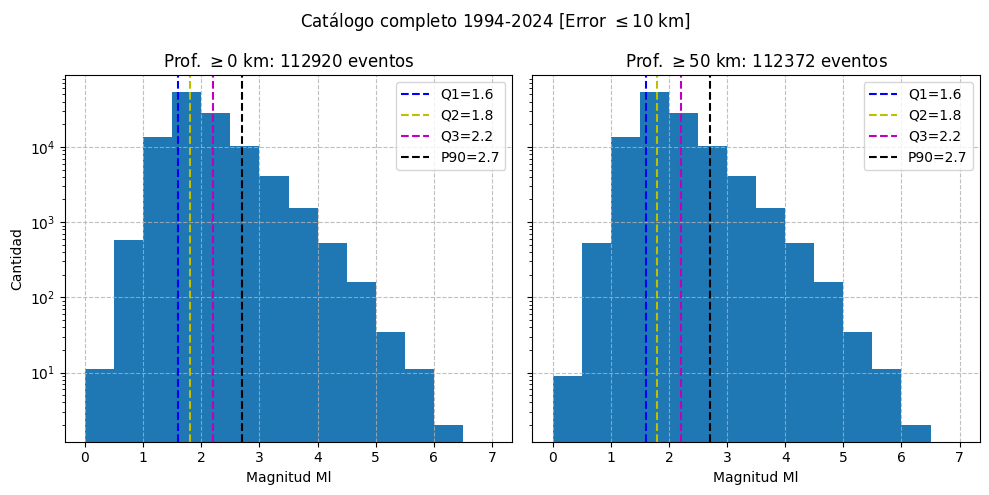

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5),
                        sharey=True,
                        sharex=True,
                        tight_layout=True)

idx = 0
profTitulo = [0, 50]

for datos in [df_Filtrado_err10km, df_Filtrado_err10km_50km]:
  Q1 = np.round(datos['MAGNITUD Ml'].quantile(0.25), 2)
  Q2 = np.round(datos['MAGNITUD Ml'].quantile(0.5), 2)
  Q3 = np.round(datos['MAGNITUD Ml'].quantile(0.75), 2)
  P90 = np.round(datos['MAGNITUD Ml'].quantile(0.90), 2)

  axs[idx].hist(datos['MAGNITUD Ml'], bins=14, range=(0,7))
  axs[idx].axvline(x= Q1,
                    ls='--',
                    color='b',
                    label='Q1={}'.format(Q1))
  axs[idx].axvline(x= Q2,
                    ls='--',
                    color='y',
                    label='Q2={}'.format(Q2))
  axs[idx].axvline(x= Q3,
                    ls='--',
                    color='m',
                    label='Q3={}'.format(Q3))
  axs[idx].axvline(x= P90,
                    ls='--',
                    color='k',
                    label='P90={}'.format(P90))

  axs[idx].legend()
  axs[idx].set_yscale('log')

  axs[idx].grid(ls='--', alpha=0.8)
  axs[idx].set_xlabel('Magnitud Ml')
  axs[idx].set_title('Prof. $\geq {}$ km: {} eventos'.format(profTitulo[idx] ,len(datos)))

  idx += 1

axs[0].set_ylabel('Cantidad')


plt.suptitle('Catálogo completo 1994-2024 [Error $\leq 10$ km]')

plt.savefig((pathSaveFiguras + 'histEventos_1994_2024_err10km_magnitudes.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

# DF to use

Considering the filtering of events with errors in their location less than 10 km, it is observed that the events would be located at depths greater than 100 km.

The number of events with magnitudes $\geq 4.5$ will be compared for the entire unfiltered catalog and those of the filtered catalog, errors $\leq 10$ km and depths $\geq 50$ km.


In [ ]:
print('Cantidad de eventos con Ml >=4.5')
print('Cátalogo completo:', sum(df_Filtrado['MAGNITUD Ml'] >= 4.5))
print('Cátalogo [Error <=10 km][Prof. >=50 km]:', sum(df_Filtrado_err10km_50km['MAGNITUD Ml'] >= 4.5))

Cantidad de eventos con Ml >=4.5
Cátalogo completo: 504
Cátalogo [Error <=10 km][Prof. >=50 km]: 206


## Histograms Ml >=4.0 and >=4.5 Full catalogue

More than 300 events with Ml $\geq 4.5$ are being lost, so histograms will be made for events with magnitudes $\geq 4.0$ and $\geq 4.5$.

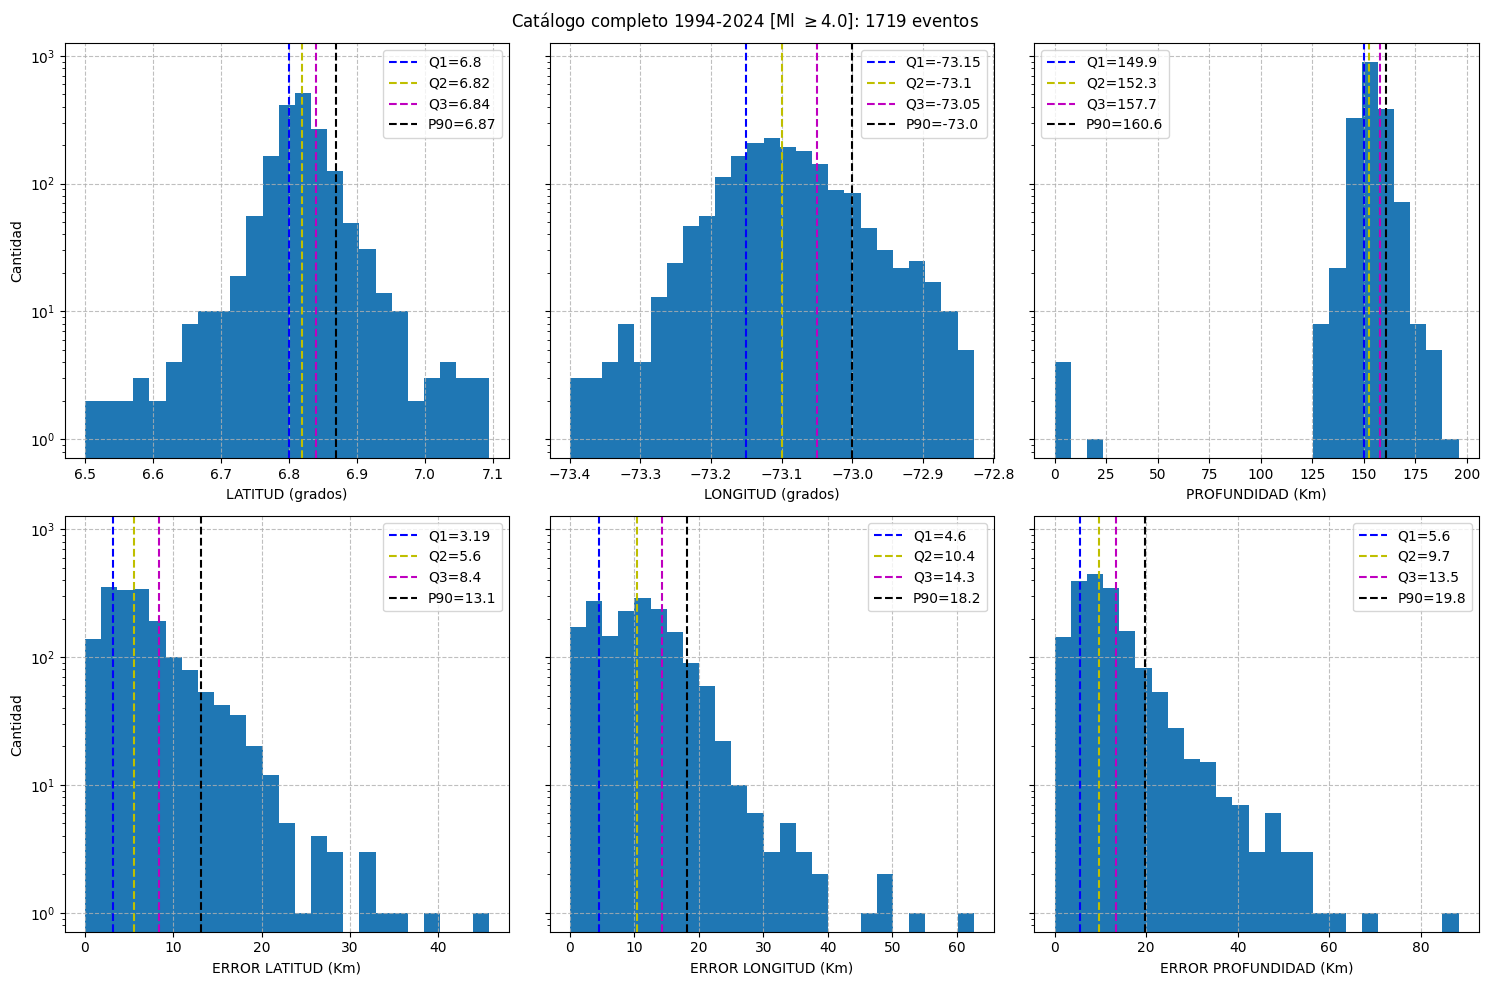

In [ ]:
columnas = ['LATITUD (grados)', 'LONGITUD (grados)', 'PROFUNDIDAD (Km)',
            'ERROR LATITUD (Km)','ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)']

df_Filtrado_ml4 = df_Filtrado[df_Filtrado['MAGNITUD Ml'] >= 4.0]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True, tight_layout=True)
for i in range(len(columnas)):
  Q1 = np.round(df_Filtrado_ml4[columnas[i]].quantile(0.25), 2)
  Q2 = np.round(df_Filtrado_ml4[columnas[i]].quantile(0.5), 2)
  Q3 = np.round(df_Filtrado_ml4[columnas[i]].quantile(0.75), 2)
  P90 = np.round(df_Filtrado_ml4[columnas[i]].quantile(0.90), 2)

  if i < 3:
    axs[0, i].hist(df_Filtrado_ml4[columnas[i]], bins=25)
    axs[0, i].axvline(x= Q1,
                      ls='--',
                      color='b',
                      label='Q1={}'.format(Q1))
    axs[0, i].axvline(x= Q2,
                      ls='--',
                      color='y',
                      label='Q2={}'.format(Q2))
    axs[0, i].axvline(x= Q3,
                      ls='--',
                      color='m',
                      label='Q3={}'.format(Q3))
    axs[0, i].axvline(x= P90,
                      ls='--',
                      color='k',
                      label='P90={}'.format(P90))

    axs[0, i].legend()
    axs[0, i].set_yscale('log')

    axs[0, i].grid(ls='--', alpha=0.8)
    axs[0, i].set_xlabel(columnas[i])
  else:
    axs[1, i-3].hist(df_Filtrado_ml4[columnas[i]], bins=25)
    axs[1, i-3].axvline(x= Q1,
                        ls='--',
                        color='b',
                        label='Q1={}'.format(Q1))
    axs[1, i-3].axvline(x= Q2,
                        ls='--',
                        color='y',
                        label='Q2={}'.format(Q2))
    axs[1, i-3].axvline(x= Q3,
                        ls='--',
                        color='m',
                        label='Q3={}'.format(Q3))
    axs[1, i-3].axvline(x= P90,
                        ls='--',
                        color='k',
                        label='P90={}'.format(P90))
    axs[1, i-3].legend()
    axs[1, i-3].set_yscale('log')

    axs[1, i-3].grid(ls='--', alpha=0.8)
    axs[1, i-3].set_xlabel(columnas[i])

axs[0,0].set_ylabel('Cantidad')
axs[1,0].set_ylabel('Cantidad')
plt.suptitle('Catálogo completo 1994-2024 [Ml $\geq 4.0$]: {} eventos'.format(len(df_Filtrado_ml4)))

plt.savefig((pathSaveFiguras + 'histEventos_1994_2024_ml40.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

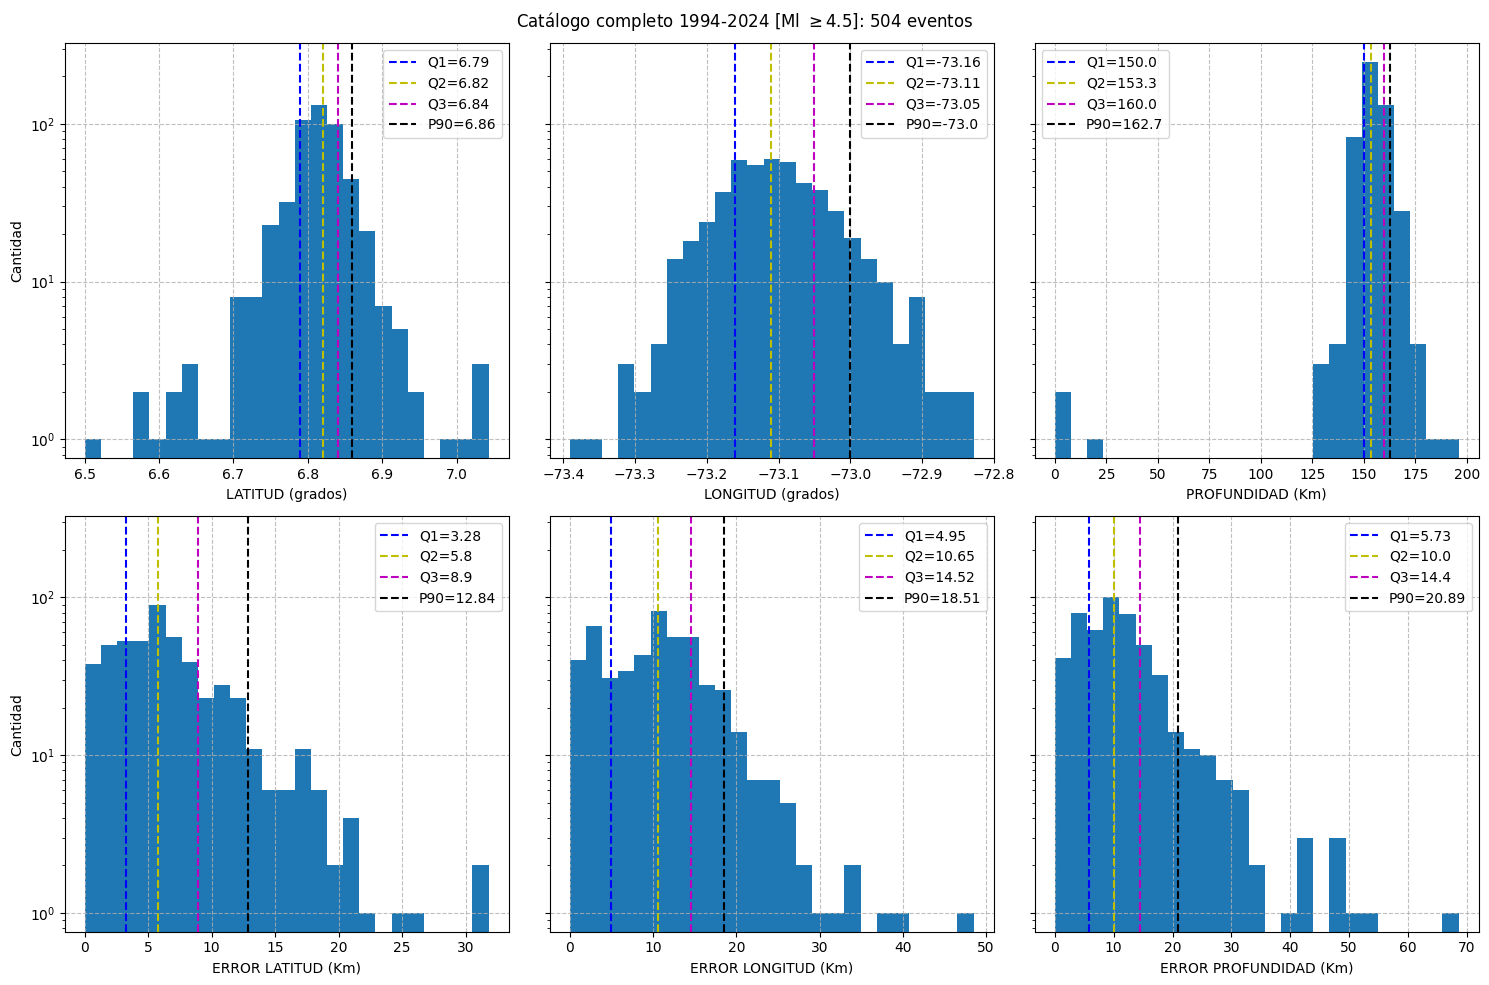

In [ ]:
columnas = ['LATITUD (grados)', 'LONGITUD (grados)', 'PROFUNDIDAD (Km)',
            'ERROR LATITUD (Km)','ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)']

df_Filtrado_ml45 = df_Filtrado[df_Filtrado['MAGNITUD Ml'] >= 4.5]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True, tight_layout=True)
for i in range(len(columnas)):
  Q1 = np.round(df_Filtrado_ml45[columnas[i]].quantile(0.25), 2)
  Q2 = np.round(df_Filtrado_ml45[columnas[i]].quantile(0.5), 2)
  Q3 = np.round(df_Filtrado_ml45[columnas[i]].quantile(0.75), 2)
  P90 = np.round(df_Filtrado_ml45[columnas[i]].quantile(0.90), 2)

  if i < 3:
    axs[0, i].hist(df_Filtrado_ml45[columnas[i]], bins=25)
    axs[0, i].axvline(x= Q1,
                      ls='--',
                      color='b',
                      label='Q1={}'.format(Q1))
    axs[0, i].axvline(x= Q2,
                      ls='--',
                      color='y',
                      label='Q2={}'.format(Q2))
    axs[0, i].axvline(x= Q3,
                      ls='--',
                      color='m',
                      label='Q3={}'.format(Q3))
    axs[0, i].axvline(x= P90,
                      ls='--',
                      color='k',
                      label='P90={}'.format(P90))

    axs[0, i].legend()
    axs[0, i].set_yscale('log')

    axs[0, i].grid(ls='--', alpha=0.8)
    axs[0, i].set_xlabel(columnas[i])
  else:
    axs[1, i-3].hist(df_Filtrado_ml45[columnas[i]], bins=25)
    axs[1, i-3].axvline(x= Q1,
                        ls='--',
                        color='b',
                        label='Q1={}'.format(Q1))
    axs[1, i-3].axvline(x= Q2,
                        ls='--',
                        color='y',
                        label='Q2={}'.format(Q2))
    axs[1, i-3].axvline(x= Q3,
                        ls='--',
                        color='m',
                        label='Q3={}'.format(Q3))
    axs[1, i-3].axvline(x= P90,
                        ls='--',
                        color='k',
                        label='P90={}'.format(P90))
    axs[1, i-3].legend()
    axs[1, i-3].set_yscale('log')

    axs[1, i-3].grid(ls='--', alpha=0.8)
    axs[1, i-3].set_xlabel(columnas[i])

axs[0,0].set_ylabel('Cantidad')
axs[1,0].set_ylabel('Cantidad')
plt.suptitle('Catálogo completo 1994-2024 [Ml $\geq 4.5$]: {} eventos'.format(len(df_Filtrado_ml45)))

plt.savefig((pathSaveFiguras + 'histEventos_1994_2024_ml45.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

Based on the results, only events at depths greater than 100 km will be considered. No filter will be applied for location errors, to avoid missing events with magnitudes greater than 4.5.

## DF 100 km deep

In [ ]:
df_Filtrado_100km.reset_index(drop=True, inplace=True)

df_Filtrado_100km

,FECHA,HORA_UTC,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),Date-Time
0,1994-01-01,00:06:37,6.839,-72.950,158.60,3.7,15.800,17.200,19.50,1994-01-01 00:06:37
1,1994-01-01,08:17:30,6.877,-72.912,166.60,4.1,14.700,19.900,16.20,1994-01-01 08:17:30
2,1994-01-02,01:55:17,6.806,-72.898,150.00,3.0,12.800,15.800,17.80,1994-01-02 01:55:17
3,1994-01-02,04:49:35,6.898,-73.095,150.00,3.1,8.300,8.700,11.30,1994-01-02 04:49:35
4,1994-01-02,05:55:47,6.736,-73.201,150.00,5.3,17.100,18.000,24.70,1994-01-02 05:55:47
...,...,...,...,...,...,...,...,...,...,...
148120,2024-02-29,17:14:57,6.763,-73.115,151.41,1.9,2.333,2.333,3.30,2024-02-29 17:14:57
148121,2024-02-29,19:34:58,6.783,-73.103,133.05,2.1,5.340,6.709,6.36,2024-02-29 19:34:58
148122,2024-02-29,21:21:08,6.809,-73.092,149.00,1.9,3.536,3.536,2.30,2024-02-29 21:21:08
148123,2024-02-29,22:13:41,6.769,-73.076,146.99,2.9,1.851,3.142,4.15,2024-02-29 22:13:41


### Save/Load DF

In [ ]:
df_Filtrado_100km.to_csv(pathDatos+'df_100km.csv', index=False)

In [ ]:
df_Filtrado_100km = pd.read_csv(pathDatos+'df_100km.csv')
df_Filtrado_100km['Date-Time'] = pd.to_datetime(df_Filtrado_100km['Date-Time'], yearfirst=True)
df_Filtrado_100km.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148125 entries, 0 to 148124
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   148125 non-null  object        
 1   HORA_UTC                148125 non-null  object        
 2   LATITUD (grados)        148125 non-null  float64       
 3   LONGITUD (grados)       148125 non-null  float64       
 4   PROFUNDIDAD (Km)        148125 non-null  float64       
 5   MAGNITUD Ml             148125 non-null  float64       
 6   ERROR LATITUD (Km)      148125 non-null  float64       
 7   ERROR LONGITUD (Km)     148125 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  148125 non-null  float64       
 9   Date-Time               148125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 11.3+ MB


## Time vs Ml

<ipython-input-66-250a35179202>:55: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig((pathSaveFiguras + 'tiempo_1994_2024_100km.png'),
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


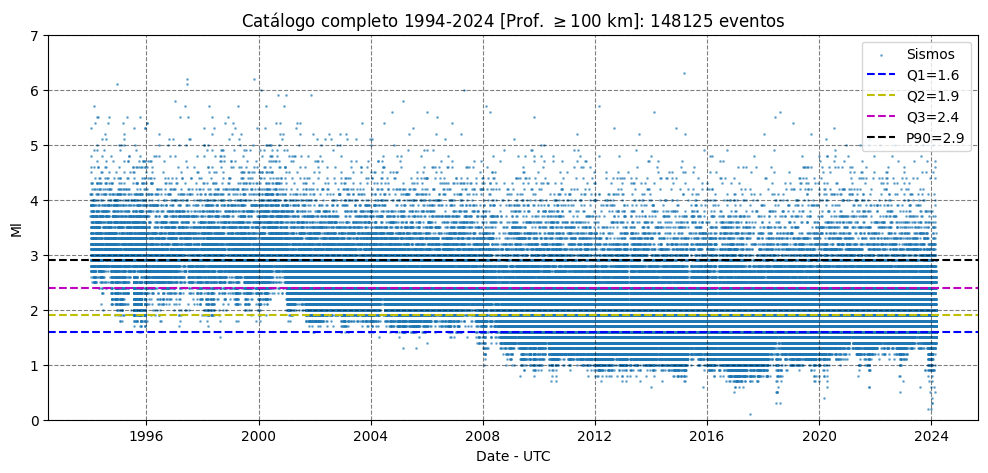

In [ ]:
plt.figure(figsize=(12,5))

plt.scatter(df_Filtrado_100km['Date-Time'],
            df_Filtrado_100km['MAGNITUD Ml'],
            s=1,
            label='Sismos',
            alpha=0.5)

Q1 = df_Filtrado_100km['MAGNITUD Ml'].quantile(0.25)
Q2 = df_Filtrado_100km['MAGNITUD Ml'].quantile(0.5)
Q3 = df_Filtrado_100km['MAGNITUD Ml'].quantile(0.75)
P90 = df_Filtrado_100km['MAGNITUD Ml'].quantile(0.90)

left, right = plt.xlim()

plt.hlines(y= Q1,
           xmin=left,
           xmax=right,
           ls='--',
           color='b',
           label='Q1={}'.format(Q1))

plt.hlines(y= Q2,
           xmin=left,
           xmax=right,
           ls='--',
           color='y',
           label='Q2={}'.format(Q2))

plt.hlines(y= Q3,
           xmin=left,
           xmax=right,
           ls='--',
           color='m',
           label='Q3={}'.format(Q3))

plt.hlines(y= P90,
           xmin=left,
           xmax=right,
           ls='--',
           color='k',
           label='P90={}'.format(P90))


plt.grid(ls='--', color='k', alpha=0.5)
plt.xlim(left, right)
plt.ylim(0,7)

plt.xlabel('Date - UTC')
plt.ylabel('Ml')
plt.legend()

plt.title('Catálogo completo 1994-2024 [Prof. $\geq 100$ km]: {} eventos'.format(len(df_Filtrado_100km)))

plt.savefig((pathSaveFiguras + 'tiempo_1994_2024_100km.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

# Ley Gutenberg-Richter

[Gutenberg-Richter Law: Wikipedia](https://es.wikipedia.org/wiki/Ley_de_Gutenberg-Richter#:~:text=Los%20terremotos%20más%20grandes%20son,de%20magnitud%205%20o%20superior.)


The Gutenberg-Richter Law is a fundamental principle in the field of seismology that describes the relationship between the magnitude of earthquakes and their frequency of occurrence. The basic formulation of the Gutenberg-Richter Law is:

$$
\begin{equation}
\log_{10}(N) = a - bM \\
N = 10^{a-bM}
\end{equation}
$$

Where:
- $N$ is the total accumulated number of earthquakes with magnitude $\geq M$, per unit of time and area.
- $a$ and $b$ are empirical constants determined from observational data, which vary in time or time window.

This law states that the number of earthquakes of a given magnitude decreases exponentially as the magnitude increases. In other words, there are many more small earthquakes than large ones, and large earthquakes are less frequent but more destructive.

The Gutenberg-Richter Law is fundamental to understanding the distribution of earthquakes and to assessing seismic risk in different regions of the world.

---
**Earthquake return periods**. The number of earthquakes per year is theoretically calculated by dividing the value a by the observation period (T).

$$
\begin{equation}
a_{1} = \frac{a}{\log(T)}
\end{equation}
$$

---
The number of cumulative earthquake frequencies per year, also known as the **seismicity index**, is:

$$
\begin{equation}
N_{1}(m) = 10^{a_{1}-bm}
\end{equation}
$$

---
The **probability of occurrence** of one or more earthquakes greater than \( m \) in period \( T \) can be formulated as:

$$
\begin{equation}
P(m, T) = \left( 1 - e^{-N(m)T} \right)
\end{equation}
$$

---
Given $N_1(m)$, the mean value of earthquake return periods can be calculated destructive:

$$
\begin{equation}
\theta = \frac{1}{N_1(m)} [years]
\end{equation}
$$







In [ ]:
np.round(df_Filtrado_100km.describe(), 2)

,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km)
count,148125.00,148125.00,148125.00,148125.00,148125.00,148125.00,148125.00
mean,6.80,-73.13,143.92,2.06,4.63,6.88,7.07
std,0.05,0.08,7.81,0.62,3.21,6.13,4.89
min,6.50,-73.40,100.00,0.10,0.00,0.00,0.00
25%,6.77,-73.17,140.08,1.60,2.62,3.10,4.20
50%,6.80,-73.14,144.65,1.90,4.10,5.19,6.50
75%,6.82,-73.10,148.50,2.40,5.80,8.70,8.85
max,7.10,-72.80,436.50,6.30,99.90,99.90,99.90


In [ ]:
# The number of events >= the magnitude of interest will be counted
# from 0.0 to 6.25, 6.5 is entered because the last one is not taken
# in steps of 0.25
N_values = np.array([])
magnitudes = np.arange(0.0, 6.5, 0.25)
print('Magnitudes: ', magnitudes)
for i in magnitudes:
  sumar_cantidad = (df_Filtrado_100km['MAGNITUD Ml'] >= i).sum()
  N_values = np.append(N_values, sumar_cantidad)

N_values

Magnitudes:  [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25]


array([1.48125e+05, 1.48122e+05, 1.48116e+05, 1.48048e+05, 1.47535e+05,
       1.42342e+05, 1.31657e+05, 9.51500e+04, 6.95630e+04, 4.38570e+04,
       3.18990e+04, 1.93190e+04, 1.35890e+04, 7.59500e+03, 5.05600e+03,
       2.67800e+03, 1.71400e+03, 8.28000e+02, 5.01000e+02, 2.40000e+02,
       1.47000e+02, 6.90000e+01, 4.00000e+01, 1.20000e+01, 7.00000e+00,
       1.00000e+00])

In [ ]:
# The magnitude of completeness of the catalogue will be considered from 2.5 considering
# the results of Time vs Ml where Q3=2.4
# in this way ensuring that information is available for years prior to 2008
Mc = 2.5
filtroMc = magnitudes >= Mc
x_regLin = np.array(magnitudes[filtroMc])
x_regLin = np.reshape(x_regLin, (-1,1))
y_regLin = np.log10(N_values[filtroMc])
print(len(x_regLin))
print(len(y_regLin))

print(x_regLin)
print(y_regLin)

16
16
[[2.5 ]
 [2.75]
 [3.  ]
 [3.25]
 [3.5 ]
 [3.75]
 [4.  ]
 [4.25]
 [4.5 ]
 [4.75]
 [5.  ]
 [5.25]
 [5.5 ]
 [5.75]
 [6.  ]
 [6.25]]
[4.50377707 4.28598464 4.1331875  3.88052778 3.70380707 3.42781057
 3.23401082 2.91803034 2.69983773 2.38021124 2.16731733 1.83884909
 1.60205999 1.07918125 0.84509804 0.        ]


In [ ]:
type(x_regLin)

numpy.ndarray

In [ ]:
type(y_regLin)

numpy.ndarray

In [ ]:
modeloRL = LinearRegression()
modeloRL.fit(x_regLin, y_regLin)

puntaje_modeloRL = modeloRL.score(x_regLin, y_regLin)
print('Score: ', puntaje_modeloRL)

Score:  0.9765275630812853


In [ ]:
b_value = -1*np.round(modeloRL.coef_[0], 2) # This is the coefficient or slope m
# b value is multiplied by -1 because it must be positive, in the expression it is already negative
a_value = np.round(modeloRL.intercept_, 2) # This is the intercept or cut-off point b
print('a value: ', a_value)
print('b value: ', b_value)

a value:  7.52
b value:  1.11


Replacing the basic formulation of the Gutenberg-Richter Law, we have:

$$
\begin{equation}
\log_{10}(N) = 7.52 - 1.11M \\
N = 10^{7.52-1.11M}
\end{equation}
$$

In [ ]:
# to know the value of X when y=0
# a_value / b_value
y0 = a_value / b_value
y0

6.774774774774774

##Graphic GR Law

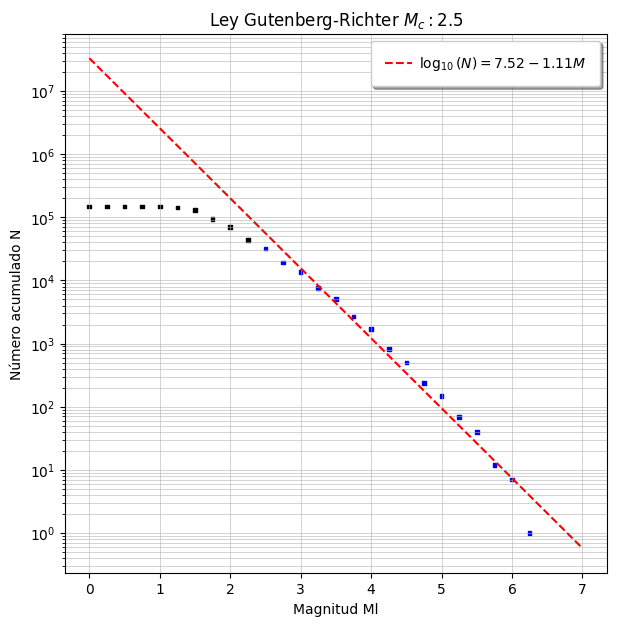

In [ ]:
# Graph the result of the GR law
clr_ley= []
for i in magnitudes:
  if i < Mc:
    clr_ley.append('k')
  else:
    clr_ley.append('b')

fig, ax= plt.subplots(1, figsize=(7,7))
ax.scatter(magnitudes, N_values, c=clr_ley, s=7, marker='s')
ax.plot(np.array([[0],[7]]), 10**modeloRL.predict(np.array([[0],[7]])),
        color='red',
        ls='--',
        label= '$\log_{10}$'+'$(N)={}-{}M$'.format(a_value, b_value) )


ax.set_yscale('log')
ax.set_xlabel('Magnitud Ml')
ax.set_ylabel('Número acumulado N')
ax.legend(loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1 ,handletextpad= 0.5)
plt.grid(True, which='both', linewidth=0.4)
plt.title(f'Ley Gutenberg-Richter $M_c:{Mc}$')

plt.savefig((pathSaveFiguras + 'LeyGutenbergRichter.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

## Return period

In [ ]:
# Number of events per year
T_enYears = (2024 - 1994) + (2/12) # the 2 months of 2024 are added
print('Años de estudio (T): ', T_enYears)

# number of events per year a_1
a_1 = a_value / np.log10(T_enYears)
print('Eventos por año (a_1): ', 10**a_1)

# Cumulative frequency of events per year or seismicity index
# is calculated for m=4.5
N1_45 = 10**(a_1-(b_value*4.5))
print('Frecuencia acumulada N_1(4.5): ', N1_45)

# Probability of an event with ml >= 4.5 occurring in 1 year
P_45_1year = 1-np.exp((-1*N1_45*1))
print('Probabilidad que ocurra un evento de ml >= 4.5 en 1 año: ', P_45_1year)

# Return period
theta = 1/N1_45 # years
print('Retorno cada: ', theta, ' años')
print('Retorno cada: ', theta*365, ' días')
print('Retorno cada: ', theta*365/30, ' meses')

Años de estudio (T):  30.166666666666668
Eventos por año (a_1):  120977.43481334929
Frecuencia acumulada N_1(4.5):  1.223782874862503
Probabilidad que ocurra un evento de ml >= 4.5 en 1 año:  0.7058845421213784
Retorno cada:  0.817138416087375  años
Retorno cada:  298.25552187189186  días
Retorno cada:  9.941850729063061  meses


Considering the analysis of the Gutenberg-Richter Law, the probability of a seismic event with a magnitude $M_l \geq 4.5$ occurring in one year is $70\%$. The return period for such events is approximately 298 days, which is equivalent to approximately every 10 months.

# Filter Ml >= 2.5

The Q3 of Ml is 2.4, so events with Ml $\geq 4.5$ will be considered.

In [ ]:
df_Filtrado_100km_ml25 = df_Filtrado_100km[df_Filtrado_100km['MAGNITUD Ml'] >= 2.5].copy()
df_Filtrado_100km_ml25.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31899 entries, 0 to 148124
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   FECHA                   31899 non-null  object        
 1   HORA_UTC                31899 non-null  object        
 2   LATITUD (grados)        31899 non-null  float64       
 3   LONGITUD (grados)       31899 non-null  float64       
 4   PROFUNDIDAD (Km)        31899 non-null  float64       
 5   MAGNITUD Ml             31899 non-null  float64       
 6   ERROR LATITUD (Km)      31899 non-null  float64       
 7   ERROR LONGITUD (Km)     31899 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  31899 non-null  float64       
 9   Date-Time               31899 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 2.7+ MB


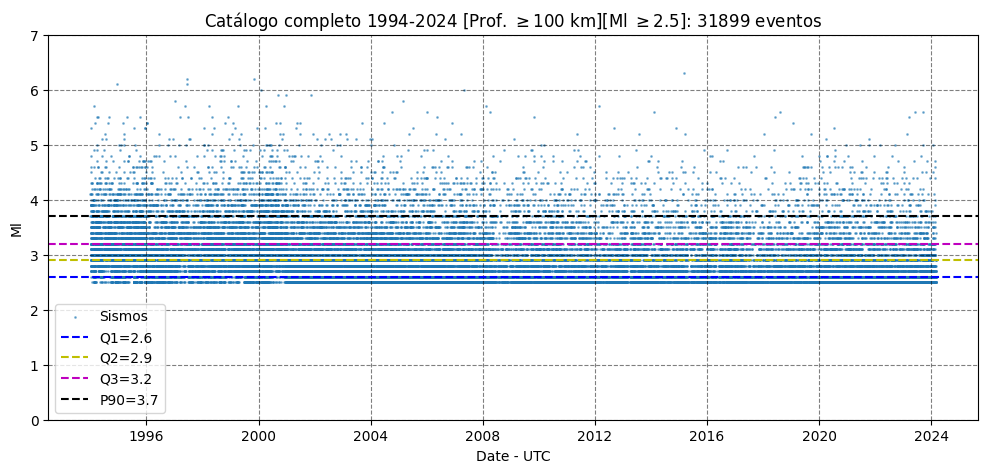

In [ ]:
plt.figure(figsize=(12,5))

plt.scatter(df_Filtrado_100km_ml25['Date-Time'],
            df_Filtrado_100km_ml25['MAGNITUD Ml'],
            s=1,
            label='Sismos',
            alpha=0.5)

Q1 = df_Filtrado_100km_ml25['MAGNITUD Ml'].quantile(0.25)
Q2 = df_Filtrado_100km_ml25['MAGNITUD Ml'].quantile(0.5)
Q3 = df_Filtrado_100km_ml25['MAGNITUD Ml'].quantile(0.75)
P90 = df_Filtrado_100km_ml25['MAGNITUD Ml'].quantile(0.90)

left, right = plt.xlim()

plt.hlines(y= Q1,
           xmin=left,
           xmax=right,
           ls='--',
           color='b',
           label='Q1={}'.format(Q1))

plt.hlines(y= Q2,
           xmin=left,
           xmax=right,
           ls='--',
           color='y',
           label='Q2={}'.format(Q2))

plt.hlines(y= Q3,
           xmin=left,
           xmax=right,
           ls='--',
           color='m',
           label='Q3={}'.format(Q3))

plt.hlines(y= P90,
           xmin=left,
           xmax=right,
           ls='--',
           color='k',
           label='P90={}'.format(P90))


plt.grid(ls='--', color='k', alpha=0.5)
plt.xlim(left, right)
plt.ylim(0,7)

plt.xlabel('Date - UTC')
plt.ylabel('Ml')
plt.legend()

plt.title('Catálogo completo 1994-2024 [Prof. $\geq 100$ km][Ml $\geq 2.5$]: {} eventos'.format(len(df_Filtrado_100km_ml25)))

plt.savefig((pathSaveFiguras + 'tiempo_1994_2024_100km_ml25.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

# Maps per year

## Ml >= 2.5

In [ ]:
years = np.arange(1994, 2025)
eventsPerYear = []

for year in years:
  df_filtrado = df_Filtrado_100km_ml25[df_Filtrado_100km_ml25['Date-Time'].dt.year == year]
  nE = len(df_filtrado)
  filtro_error_mayor_10km = (df_filtrado['ERROR LATITUD (Km)'] > 10) | (df_filtrado['ERROR LONGITUD (Km)'] > 10)
  filtro_error_menor_10km = (df_filtrado['ERROR LATITUD (Km)'] <= 10) | (df_filtrado['ERROR LONGITUD (Km)'] <= 10)

  fig, ax = plt.subplots(figsize=(8,7))
  ax.scatter(df_filtrado['LONGITUD (grados)'][filtro_error_menor_10km],
             df_filtrado['LATITUD (grados)'][filtro_error_menor_10km],
             s= 5, c='b', label='Error Lat. Long. $\leq 10$ km [{} eventos]'.format(sum(filtro_error_menor_10km)))
  ax.scatter(df_filtrado['LONGITUD (grados)'][filtro_error_mayor_10km],
             df_filtrado['LATITUD (grados)'][filtro_error_mayor_10km],
             s= 5, c='r', label='Error Lat. Long. $> 10$ km [{} eventos]'.format(sum(filtro_error_mayor_10km)))

  ax.set_xlabel('Longitud [grados]')
  ax.set_ylabel('Latitud [grados]')

  ax.set_ylim(6.5, 7.1)
  ax.set_xlim(-73.4, -72.8)
  #ax.axis('equal')

  cx.add_basemap(ax=ax,
                 crs='epsg:4326', # el sistema de coordenadas
                 source=xyz.OpenTopoMap,
                 reset_extent=True) # Para incluir un mapa base

  plt.grid(color='grey', ls='--', alpha=0.5)
  plt.title(f'Año {year} [Prof. $\geq 100$ km][Ml $\geq 2.5$]: {nE} eventos')

  eventsPerYear.append(nE)

  plt.legend(loc=8)

  plt.savefig((pathSaveFiguras + f'mapa_{year}.png'),
              format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

  plt.show()
  print('\n')

del(nE, df_filtrado)

Output hidden; open in https://colab.research.google.com to view.

### Events per year

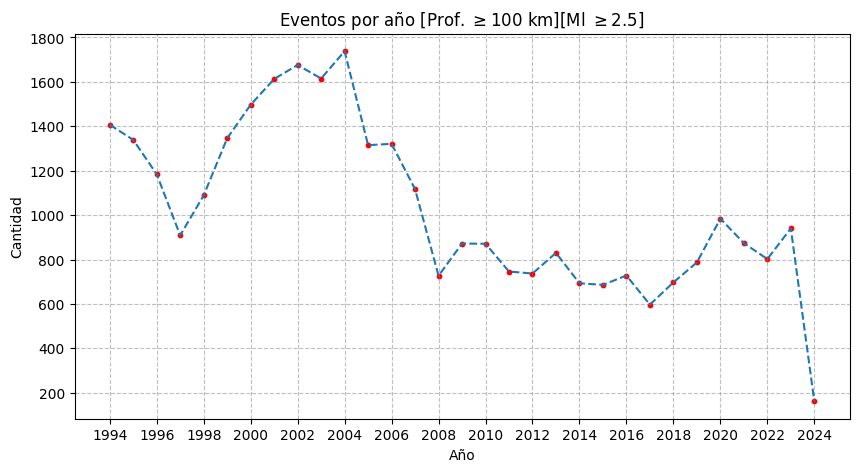

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(years, eventsPerYear, ls='--')
plt.scatter(years, eventsPerYear, c='r', s=10)

plt.xlabel('Año')
plt.ylabel('Cantidad')

plt.xticks(np.arange(1994, 2025, 2))

plt.title('Eventos por año [Prof. $\geq 100$ km][Ml $\geq 2.5$]')
plt.grid(color='grey', ls='--', alpha=0.5)

plt.savefig((pathSaveFiguras + 'eventosPorYear_ml25_100km.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

## Ml >=4.5

In [ ]:
years = np.arange(1994, 2025)
eventsPerYear = []

df_Filtrado_100km_ml45 = df_Filtrado_100km_ml25[df_Filtrado_100km_ml25['MAGNITUD Ml'] >= 4.5].copy()

for year in years:
  df_filtrado = df_Filtrado_100km_ml45[df_Filtrado_100km_ml45['Date-Time'].dt.year == year]
  nE = len(df_filtrado)
  filtro_error_mayor_10km = (df_filtrado['ERROR LATITUD (Km)'] > 10) | (df_filtrado['ERROR LONGITUD (Km)'] > 10)
  filtro_error_menor_10km = (df_filtrado['ERROR LATITUD (Km)'] <= 10) | (df_filtrado['ERROR LONGITUD (Km)'] <= 10)

  fig, ax = plt.subplots(figsize=(8,7))
  ax.scatter(df_filtrado['LONGITUD (grados)'][filtro_error_menor_10km],
             df_filtrado['LATITUD (grados)'][filtro_error_menor_10km],
             s= 5, c='b', label='Error Lat. Long. $\leq 10$ km [{} eventos]'.format(sum(filtro_error_menor_10km)))
  ax.scatter(df_filtrado['LONGITUD (grados)'][filtro_error_mayor_10km],
             df_filtrado['LATITUD (grados)'][filtro_error_mayor_10km],
             s= 5, c='r', label='Error Lat. Long. $> 10$ km [{} eventos]'.format(sum(filtro_error_mayor_10km)))

  ax.set_xlabel('Longitud [grados]')
  ax.set_ylabel('Latitud [grados]')

  ax.set_ylim(6.5, 7.1)
  ax.set_xlim(-73.4, -72.8)
  #ax.axis('equal')

  cx.add_basemap(ax=ax,
                 crs='epsg:4326', # el sistema de coordenadas
                 source=xyz.OpenTopoMap,
                 reset_extent=True) # Para incluir un mapa base

  plt.grid(color='grey', ls='--', alpha=0.5)
  plt.title(f'Año {year} [Prof. $\geq 100$ km][Ml $\geq 4.5$]: {nE} eventos')

  eventsPerYear.append(nE)

  plt.legend(loc=8)

  plt.savefig((pathSaveFiguras + f'mapa_ml45_{year}.png'),
              format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

  plt.show()
  print('\n')

del(nE, df_filtrado)

Output hidden; open in https://colab.research.google.com to view.

### Eventos por año

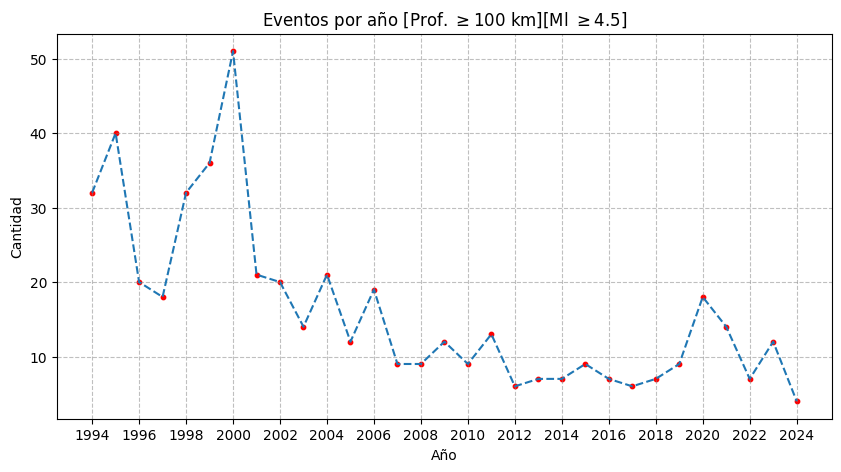

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(years, eventsPerYear, ls='--')
plt.scatter(years, eventsPerYear, c='r', s=10)

plt.xlabel('Año')
plt.ylabel('Cantidad')

plt.xticks(np.arange(1994, 2025, 2))

plt.title('Eventos por año [Prof. $\geq 100$ km][Ml $\geq 4.5$]')
plt.grid(color='grey', ls='--', alpha=0.5)

plt.savefig((pathSaveFiguras + 'eventosPorYear_ml45_100km.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

The value of 365 days will be divided by the number of events with Ml $\geq 4.5$ that occur each year, to obtain an approximation of the frequency with which events of this magnitude occur.

In [ ]:
dias_45 = np.round(365/ np.array(eventsPerYear), 2)
dias_45

array([11.41,  9.12, 18.25, 20.28, 11.41, 10.14,  7.16, 17.38, 18.25,
       26.07, 17.38, 30.42, 19.21, 40.56, 40.56, 30.42, 40.56, 28.08,
       60.83, 52.14, 52.14, 40.56, 52.14, 60.83, 52.14, 40.56, 20.28,
       26.07, 52.14, 30.42, 91.25])

In [ ]:
dias_45[:-1] # Not to take 2024

array([11.41,  9.12, 18.25, 20.28, 11.41, 10.14,  7.16, 17.38, 18.25,
       26.07, 17.38, 30.42, 19.21, 40.56, 40.56, 30.42, 40.56, 28.08,
       60.83, 52.14, 52.14, 40.56, 52.14, 60.83, 52.14, 40.56, 20.28,
       26.07, 52.14, 30.42])

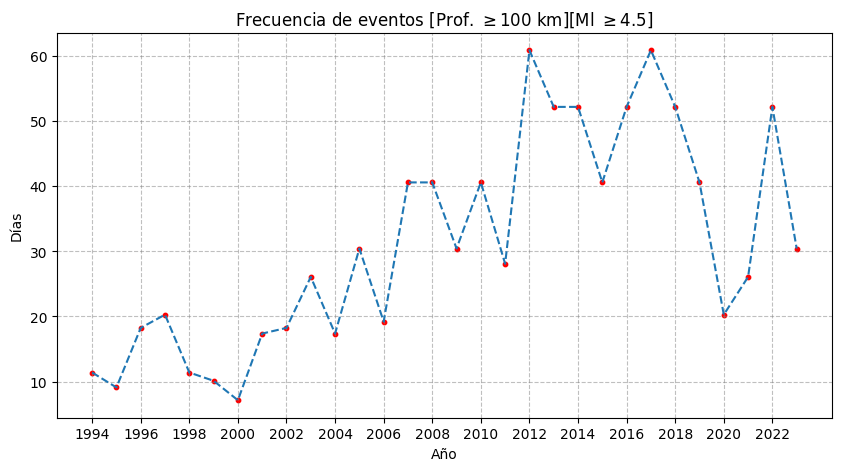

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(years[:-1], dias_45[:-1], ls='--')
plt.scatter(years[:-1], dias_45[:-1], c='r', s=10)

plt.xlabel('Año')
plt.ylabel('Días')

plt.xticks(np.arange(1994, 2024, 2))

plt.title('Frecuencia de eventos [Prof. $\geq 100$ km][Ml $\geq 4.5$]')
plt.grid(color='grey', ls='--', alpha=0.5)

plt.savefig((pathSaveFiguras + 'frecuenciaEventos_retorno_ml45_100km.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

# DF for new day

In [ ]:
df_Filtrado_100km_ml25.describe()

,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km)
count,31899.000000,31899.000000,31899.000000,31899.000000,31899.000000,31899.000000,31899.000000
mean,6.816478,-73.089218,147.987924,2.997599,5.789799,9.830206,9.616090
std,0.043255,0.083724,7.002486,0.491535,4.396119,7.017417,6.935384
min,6.500000,-73.400000,100.000000,2.500000,0.000000,0.000000,0.000000
25%,6.795000,-73.148000,144.100000,2.600000,3.000000,4.100000,5.400000
50%,6.815000,-73.100000,148.100000,2.900000,4.700000,9.000000,8.100000
75%,6.837000,-73.035000,151.340000,3.200000,7.000000,13.600000,11.800000
max,7.100000,-72.802000,210.800000,6.300000,99.900000,99.900000,99.900000


In [ ]:
dict_Dias = {'Dia':[],
             '2.5-3.0':[],
             '3.0-3.5':[],
             '3.5-4.0':[],
             '4.0-4.5':[],
             '4.5-5.0':[],
             '5.0-5.5':[],
             '5.5-':[],}

# Apparently not every day there is a record of events with depths
# greater than 50 km and magnitudes greater than 2.5
inicio = np.datetime64('1994-01-01')
fin = np.datetime64('2024-03-01')
array_fechas = np.arange(inicio, fin, dtype='datetime64[D]')

for date in array_fechas:
  df_filtrado = df_Filtrado_100km_ml25[df_Filtrado_100km_ml25['FECHA'] == str(date)]
  dict_Dias['Dia'].append(str(date))

  for ml in np.arange(2.5, 6.0, 0.5):
    if ml == 5.5:
      nE = df_filtrado['MAGNITUD Ml'] >= 5.5

      dict_Dias['5.5-'].append(sum(nE))

    else:
      nE = (df_filtrado['MAGNITUD Ml'] >= ml) & (df_filtrado['MAGNITUD Ml'] < (ml+0.5) )
      strDict = f'{ml}-{ml+0.5}'

      dict_Dias[strDict].append(sum(nE))

df_Dias = pd.DataFrame.from_dict(dict_Dias)
df_Dias['Total dia'] = df_Dias.sum(axis=1)
df_Dias

<ipython-input-126-a7202a88c402>:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_Dias['Total dia'] = df_Dias.sum(axis=1)


,Dia,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia
0,1994-01-01,0,0,1,1,0,0,0,2
1,1994-01-02,1,4,0,0,0,1,0,6
2,1994-01-03,0,1,0,1,0,0,0,2
3,1994-01-04,0,3,1,0,0,0,0,4
4,1994-01-05,2,2,1,0,1,0,0,6
...,...,...,...,...,...,...,...,...,...
11012,2024-02-25,1,0,0,0,0,0,0,1
11013,2024-02-26,6,1,0,0,0,0,0,7
11014,2024-02-27,2,0,0,0,0,0,0,2
11015,2024-02-28,4,0,0,0,0,0,0,4


## Save/Load DF

In [ ]:
df_Dias.to_csv(pathDatos+'df_Dias_v2.csv', index=False)

In [ ]:
df_Dias = pd.read_csv(pathDatos+'df_Dias_v2.csv')
df_Dias['Fecha'] = pd.to_datetime(df_Dias['Dia'], yearfirst=True)
df_Dias

,Dia,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia,Fecha
0,1994-01-01,0,0,1,1,0,0,0,2,1994-01-01
1,1994-01-02,1,4,0,0,0,1,0,6,1994-01-02
2,1994-01-03,0,1,0,1,0,0,0,2,1994-01-03
3,1994-01-04,0,3,1,0,0,0,0,4,1994-01-04
4,1994-01-05,2,2,1,0,1,0,0,6,1994-01-05
...,...,...,...,...,...,...,...,...,...,...
11012,2024-02-25,1,0,0,0,0,0,0,1,2024-02-25
11013,2024-02-26,6,1,0,0,0,0,0,7,2024-02-26
11014,2024-02-27,2,0,0,0,0,0,0,2,2024-02-27
11015,2024-02-28,4,0,0,0,0,0,0,4,2024-02-28


# Create and/X

In [ ]:
# Let's add the 3 columns of interest
df_Dias['Y'] = df_Dias[['4.5-5.0', '5.0-5.5', '5.5-']].sum(axis=1)
np.round(df_Dias.describe())

,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia,Y
count,11017.0,11017.0,11017.0,11017.0,11017.0,11017.0,11017.0,11017.0,11017.0
mean,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
std,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50%,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
75%,2.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
max,11.0,8.0,5.0,3.0,2.0,2.0,2.0,13.0,2.0


## Distances in days between 'Y'

In [ ]:
df_Dias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Dia        11017 non-null  object        
 1   2.5-3.0    11017 non-null  int64         
 2   3.0-3.5    11017 non-null  int64         
 3   3.5-4.0    11017 non-null  int64         
 4   4.0-4.5    11017 non-null  int64         
 5   4.5-5.0    11017 non-null  int64         
 6   5.0-5.5    11017 non-null  int64         
 7   5.5-       11017 non-null  int64         
 8   Total dia  11017 non-null  int64         
 9   Fecha      11017 non-null  datetime64[ns]
 10  Y          11017 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 946.9+ KB


Only the days that have a seismic event $Ml \geq 4.5$, or column 'Y', will be taken. Then, once they are sorted, the difference in dates with the next day with an event in 'Y' will be calculated.

In [ ]:
fechasConEventos = df_Dias['Fecha'][df_Dias['Y'] >= 1].copy()
fechasConEventos

1       1994-01-02
4       1994-01-05
10      1994-01-11
11      1994-01-12
47      1994-02-17
           ...    
10899   2023-11-04
10977   2024-01-21
10978   2024-01-22
11007   2024-02-20
11009   2024-02-22
Name: Fecha, Length: 480, dtype: datetime64[ns]

In [ ]:
fechasConEventos = fechasConEventos.to_numpy()

In [ ]:
diff_Dias = (fechasConEventos[1:] - fechasConEventos[:-1]) / np.timedelta64(1, 'D')
diff_Dias

array([  3.,   6.,   1.,  36.,   1.,   2.,   6.,  23.,   7.,   4.,   1.,
         3.,   2.,   7.,  37.,  15.,   1.,  15.,  12.,  11.,   4.,   6.,
         4.,  27.,   1.,   9.,  21.,  22.,  42.,  13.,  31.,   1.,   5.,
        14.,  24.,  18.,   1.,   1.,   4.,  34.,  13.,   4.,   5.,   3.,
         8.,  42.,   2.,   1.,  14.,  17.,   6.,   9.,   9.,  20.,   4.,
        13.,  15.,   7.,  14.,   5.,  12.,   7.,   2.,   1.,   7.,  12.,
         7.,   2.,   2.,  13.,  22.,  19.,   8.,   7.,  14.,  36.,  29.,
         2.,   1.,  58.,  11.,  56.,  14.,   4.,  43.,  19.,   1.,  48.,
         8.,   9.,  17.,  48.,  17.,   2.,  12.,   2.,  11.,  13.,  19.,
        49.,  33.,  10.,   8.,  72.,   4.,   2.,   3.,  39.,   6.,   1.,
         6.,  13.,   1.,  31.,   1.,   1.,   4.,  19.,  11.,   1.,  12.,
        55.,   8.,   7.,   6.,   1.,   6.,  17.,   3.,   2.,   7.,  18.,
        39.,   6.,  23.,   9.,   3.,  13.,   2.,  14.,   9.,   6.,  46.,
         5.,   1.,  10.,  17.,   1.,  11.,  16.,   

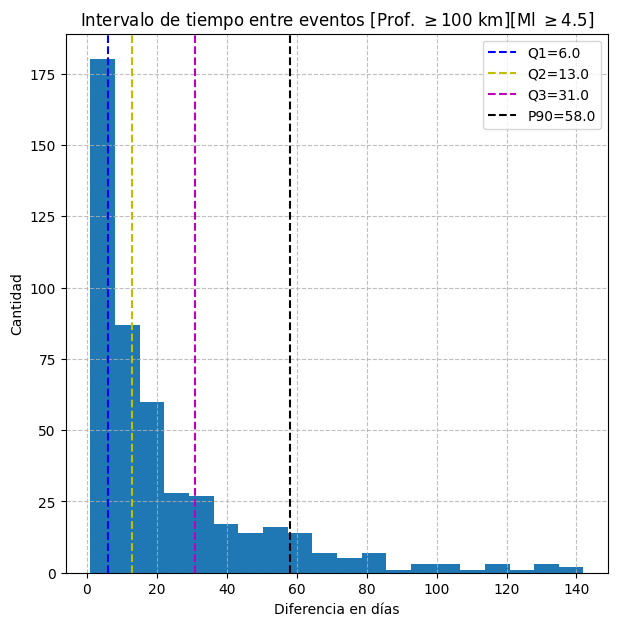

In [ ]:
Q1 = np.round(np.quantile(diff_Dias, 0.25), 2)
Q2 = np.round(np.quantile(diff_Dias, 0.50), 2)
Q3 = np.round(np.quantile(diff_Dias, 0.75), 2)
P90 = np.round(np.quantile(diff_Dias, 0.90), 2)

plt.figure(figsize=(7,7))
plt.hist(diff_Dias, bins=20)

plt.axvline(x= Q1,
            ls='--',
            color='b',
            label='Q1={}'.format(Q1))
plt.axvline(x= Q2,
            ls='--',
            color='y',
            label='Q2={}'.format(Q2))
plt.axvline(x= Q3,
            ls='--',
            color='m',
            label='Q3={}'.format(Q3))
plt.axvline(x= P90,
            ls='--',
            color='k',
            label='P90={}'.format(P90))

plt.ylabel('Cantidad')
plt.xlabel('Diferencia en días')
plt.title('Intervalo de tiempo entre eventos [Prof. $\geq 100$ km][Ml $\geq 4.5$]')

plt.legend()
plt.grid(ls='--', alpha=0.8)

plt.savefig((pathSaveFiguras + 'histIntervaloTiempoEventos_retorno_ml45_100km.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)


plt.show()

When calculating the distance or time interval that has passed between events of $Ml \geq 4.5$.
- $75\%$ of the events occurred with a difference of $\leq 31$ days.
- $90\%$ of the events occurred with a difference of $\leq 58$ days.


## 6 months

In [ ]:
y = []
X = []

dias_Considerar = 180 # for 6 months

for dias in range(dias_Considerar-1, len(df_Dias)-6):
  di_ = dias_Considerar-1
  datos = df_Dias[['2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0', '5.0-5.5', '5.5-']].iloc[dias-di_:dias+1].to_numpy()
  #print(datos.shape)
  datos = np.reshape(datos, (1,-1))
  #print(datos.shape)
  X.append(datos.tolist()[0])

  target = df_Dias['Y'].iloc[dias+1:dias+7].sum()

  if target > 0 :
    y.append(1)
  else:
    y.append(0)
y = np.reshape(np.array(y), (-1,1))
X = np.array(X)

In [ ]:
y.shape

(10832, 1)

In [ ]:
X.shape

(10832, 1260)

In [ ]:
df_yX_6meses = pd.DataFrame(np.concatenate((X,y), axis=1))
df_yX_6meses

,0,1,2,3,4,5,6,7,8,9,...,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260
0,0,0,1,1,0,0,0,1,4,0,...,0,0,0,0,0,0,0,0,0,1
1,1,4,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,1,0,0,0,0,3,1,...,0,0,1,1,1,0,0,0,0,1
3,0,3,1,0,0,0,0,2,2,1,...,0,0,1,2,1,0,0,0,0,1
4,2,2,1,0,1,0,0,2,2,2,...,0,0,1,3,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10827,1,3,0,0,0,0,0,1,1,0,...,0,0,0,2,0,0,0,0,0,1
10828,1,1,0,0,0,0,0,0,0,1,...,0,0,2,0,0,1,1,0,0,1
10829,0,0,1,0,0,0,0,1,2,0,...,0,0,1,1,0,0,0,0,0,1
10830,1,2,0,0,0,0,0,2,2,1,...,0,0,2,0,1,0,1,0,0,0


### Split

In [ ]:
# Events < 2022 will be used for training
# and those >= 2022 will be used for prediction
filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

y2021 = df_yX_6meses.iloc[:,-1][filtro2022].to_numpy()
X2021 = df_yX_6meses.iloc[:,:-1][filtro2022].to_numpy()

y2022 = df_yX_6meses.iloc[:,-1][filtro2023].to_numpy()
X2022 = df_yX_6meses.iloc[:,:-1][filtro2023].to_numpy()

### Save them

In [ ]:
prefijo = pathDatos + '6meses'
print(prefijo)
np.savetxt(f'{prefijo}_y2021.txt', y2021)
np.savetxt(f'{prefijo}_X2021.txt', X2021)
np.savetxt(f'{prefijo}_y2022.txt', y2022)
np.savetxt(f'{prefijo}_X2022.txt', X2022)


/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/6meses


## 12 months

In [ ]:
y = []
X = []

dias_Considerar = 365 # for 12 months

for dias in range(dias_Considerar-1, len(df_Dias)-6):
  di_ = dias_Considerar-1
  datos = df_Dias[['2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0', '5.0-5.5', '5.5-']].iloc[dias-di_:dias+1].to_numpy()
  #print(datos.shape)
  datos = np.reshape(datos, (1,-1))
  #print(datos.shape)
  X.append(datos.tolist()[0])

  target = df_Dias['Y'].iloc[dias+1:dias+7].sum()

  if target > 0 :
    y.append(1)
  else:
    y.append(0)
y = np.reshape(np.array(y), (-1,1))
X = np.array(X)

In [ ]:
y.shape

(10647, 1)

In [ ]:
X.shape

(10647, 2555)

In [ ]:
df_yX_12meses = pd.DataFrame(np.concatenate((X,y), axis=1))
df_yX_12meses

,0,1,2,3,4,5,6,7,8,9,...,2546,2547,2548,2549,2550,2551,2552,2553,2554,2555
0,0,0,1,1,0,0,0,1,4,0,...,0,0,1,2,1,0,0,0,0,0
1,1,4,0,0,0,1,0,0,1,0,...,0,0,2,1,2,1,0,0,0,0
2,0,1,0,1,0,0,0,0,3,1,...,0,0,1,2,2,0,0,0,0,0
3,0,3,1,0,0,0,0,2,2,1,...,0,0,1,0,1,0,0,0,0,0
4,2,2,1,0,1,0,0,2,2,2,...,0,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10642,1,0,0,0,0,0,0,1,0,1,...,0,0,0,2,0,0,0,0,0,1
10643,1,0,1,0,0,0,0,5,0,0,...,0,0,2,0,0,1,1,0,0,1
10644,5,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
10645,0,0,0,0,0,0,0,4,3,1,...,0,0,2,0,1,0,1,0,0,0


### Split

In [ ]:
# Events < 2022 will be used for training
# and those >= 2022 will be used for prediction
filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

y2021 = df_yX_12meses.iloc[:,-1][filtro2022].to_numpy()
X2021 = df_yX_12meses.iloc[:,:-1][filtro2022].to_numpy()

y2022 = df_yX_12meses.iloc[:,-1][filtro2023].to_numpy()
X2022 = df_yX_12meses.iloc[:,:-1][filtro2023].to_numpy()

### Save them

In [ ]:
prefijo = pathDatos + '12meses'
print(prefijo)
np.savetxt(f'{prefijo}_y2021.txt', y2021)
np.savetxt(f'{prefijo}_X2021.txt', X2021)
np.savetxt(f'{prefijo}_y2022.txt', y2022)
np.savetxt(f'{prefijo}_X2022.txt', X2022)

/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/12meses


# MLPClass Training

## 6 months

In [ ]:
# Files are loaded
X2022 = np.loadtxt(pathDatos+'6meses_X2022.txt')
y2022 = np.loadtxt(pathDatos+'6meses_y2022.txt')
X2021 = np.loadtxt(pathDatos+'6meses_X2021.txt')
y2021 = np.loadtxt(pathDatos+'6meses_y2021.txt')

In [ ]:
X2021.shape

(10048, 1260)

The layers of the 8 models that obtained outstanding results during the training of version 1 will be analyzed. The score is required to be greater than 0.9.

```python
[2000, 5]
[1500, 5]
[420, 5]
[210, 5] # esta 5 veces
```


In [ ]:
letras = '6meses_'
pathSave = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v2/'

# Proposal of 4 structures considering the 8 previous models
estuctura = [[2000, 5],
             [1500, 5],
             [420, 5],
             [210, 5]]

scoreInteres = 0.9
intentos = 5

for hl in estuctura:
  c = 0

  while c <= intentos:
    print('\n ', c)

    modelo_MLPClass = MLPClassifier(hidden_layer_sizes=tuple(hl),
                                  activation='relu', #identity, logistic, tanh, relu
                                  early_stopping=False, solver='adam', max_iter=30)#, random_state= 0)
    # Se entrena
    tinicio = time.perf_counter()

    modelo_MLPClass.fit(X2021, y2021)

    tfinal = time.perf_counter()
    tiempo = tfinal - tinicio

    print('Segundos empleados: ',tiempo)

    scoreMLPClass = modelo_MLPClass.score(X2021, y2021)
    print('Score: ', scoreMLPClass)


    if scoreMLPClass >= scoreInteres:
      # guardar modelo
      Name = letras + f'_hl_{hl[0]}_{hl[1]}_int' + str(c) + '_scr' + str(round(scoreMLPClass, 3)) + '.joblib'
      dump(modelo_MLPClass, pathSave+Name)
      print(Name)
      break

    if c == intentos:
      print('Nada ...')
    c += 1


  0


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Segundos empleados:  38.51867001800019
Score:  1.0
6meses__hl_210_5_int0_scr1.0.joblib


## 12 months

In [ ]:
# Files are loaded
X2022 = np.loadtxt(pathDatos+'12meses_X2022.txt')
y2022 = np.loadtxt(pathDatos+'12meses_y2022.txt')
X2021 = np.loadtxt(pathDatos+'12meses_X2021.txt')
y2021 = np.loadtxt(pathDatos+'12meses_y2021.txt')

In [ ]:
X2021.shape

(9863, 2555)

The layers of the 8 models that obtained outstanding results during the training of version 1 will be analyzed. The score is required to be greater than 0.9.

```python
[2000, 5]
[1500, 5]
[420, 5]
[210, 5] # esta 5 veces
```

In [ ]:
estuctura[-1:]

[[210, 5]]

When [2000, 5] is considered, a score of 0.77 cannot be exceeded. Therefore, a lower score of 0.70 will be allowed for this model.

In [ ]:
letras = '12meses_'
pathSave = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v2/'

# Proposal of 4 structures considering the 8 previous models
estuctura = [[2000, 5],
             [1500, 5],
             [420, 5],
             [210, 5]]

scoreInteres = 0.9
intentos = 5

for hl in estuctura:
  c = 0

  while c <= intentos:
    print('\n ', c)

    modelo_MLPClass = MLPClassifier(hidden_layer_sizes=tuple(hl),
                                  activation='relu', #identity, logistic, tanh, relu
                                  early_stopping=False, solver='adam', max_iter=30)#, random_state= 0)
    # Se entrena
    tinicio = time.perf_counter() # Segundos

    modelo_MLPClass.fit(X2021, y2021)

    tfinal = time.perf_counter() # Segundos
    tiempo = tfinal - tinicio

    print('Segundos empleados: ',tiempo)

    scoreMLPClass = modelo_MLPClass.score(X2021, y2021)
    print('Score: ', scoreMLPClass)


    if scoreMLPClass >= scoreInteres:
      # guardar modelo
      Name = letras + f'_hl_{hl[0]}_{hl[1]}_int' + str(c) + '_scr' + str(round(scoreMLPClass, 3)) + '.joblib'
      dump(modelo_MLPClass, pathSave+Name)
      print(Name)
      break

    if c == intentos:
      print('Nada ...')
    c += 1


  0


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Segundos empleados:  51.544493490000605
Score:  0.7731927405454729

  1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Segundos empleados:  49.11224683600085
Score:  0.9962486059008415
12meses__hl_210_5_int1_scr0.996.joblib


# Model graphs

In [ ]:
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/'

## Load Catalogs

In [ ]:
df = pd.read_csv(pathDatos+'df_Total_1994_2024.csv')
df['Date-Time'] = pd.to_datetime(df['Date-Time'], yearfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148986 entries, 0 to 148985
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   148986 non-null  object        
 1   HORA_UTC                148986 non-null  object        
 2   LATITUD (grados)        148986 non-null  float64       
 3   LONGITUD (grados)       148986 non-null  float64       
 4   PROFUNDIDAD (Km)        148986 non-null  float64       
 5   MAGNITUD Ml             148986 non-null  float64       
 6   ERROR LATITUD (Km)      148910 non-null  float64       
 7   ERROR LONGITUD (Km)     148910 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  148910 non-null  float64       
 9   Date-Time               148986 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 11.4+ MB


In [ ]:
df_Dias = pd.read_csv(pathDatos+'df_Dias_v2.csv')
df_Dias['Fecha'] = pd.to_datetime(df_Dias['Dia'], yearfirst=True)
df_Dias

,Dia,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia,Fecha
0,1994-01-01,0,0,1,1,0,0,0,2,1994-01-01
1,1994-01-02,1,4,0,0,0,1,0,6,1994-01-02
2,1994-01-03,0,1,0,1,0,0,0,2,1994-01-03
3,1994-01-04,0,3,1,0,0,0,0,4,1994-01-04
4,1994-01-05,2,2,1,0,1,0,0,6,1994-01-05
...,...,...,...,...,...,...,...,...,...,...
11012,2024-02-25,1,0,0,0,0,0,0,1,2024-02-25
11013,2024-02-26,6,1,0,0,0,0,0,7,2024-02-26
11014,2024-02-27,2,0,0,0,0,0,0,2,2024-02-27
11015,2024-02-28,4,0,0,0,0,0,0,4,2024-02-28


## Load models

In [ ]:
listaModelos = !ls /content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v2
listaModelos

['12meses__hl_1500_5_int2_scr0.996.joblib  6meses__hl_1500_5_int0_scr0.998.joblib',
 '12meses__hl_2000_5_int0_scr0.773.joblib  6meses__hl_2000_5_int0_scr0.999.joblib',
 '12meses__hl_210_5_int0_scr0.999.joblib\t 6meses__hl_210_5_int0_scr1.0.joblib',
 '12meses__hl_210_5_int1_scr0.996.joblib\t 6meses__hl_210_5_int1_scr0.996.joblib',
 '12meses__hl_420_5_int2_scr0.957.joblib\t 6meses__hl_420_5_int0_scr0.987.joblib']

In [ ]:
import re
pathModelos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v2/'
listaModelos = !ls /content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v2
listaTemp = []
for i in range(len(listaModelos)):
  if len(re.split(r'\t|  ', listaModelos[i])) == 1:
    a = re.split(r'\t|  ', listaModelos[i])
    listaTemp.append(a[0])
  else:
    a = re.split(r'\t|  ', listaModelos[i])
    listaTemp.append(a[0])
    listaTemp.append(a[1])
listaModelos = np.reshape(np.array(listaTemp), (1,-1))
del(listaTemp)
listaModelos = listaModelos[0]
listaModelos

array(['12meses__hl_1500_5_int2_scr0.996.joblib',
       '6meses__hl_1500_5_int0_scr0.998.joblib',
       '12meses__hl_2000_5_int0_scr0.773.joblib',
       '6meses__hl_2000_5_int0_scr0.999.joblib',
       '12meses__hl_210_5_int0_scr0.999.joblib',
       ' 6meses__hl_210_5_int0_scr1.0.joblib',
       '12meses__hl_210_5_int1_scr0.996.joblib',
       ' 6meses__hl_210_5_int1_scr0.996.joblib',
       '12meses__hl_420_5_int2_scr0.957.joblib',
       ' 6meses__hl_420_5_int0_scr0.987.joblib'], dtype='<U39')

In [ ]:
listaModelos[-1] = listaModelos[-1][1:]
listaModelos[5] = listaModelos[5][1:]
listaModelos[7] = listaModelos[7][1:]
listaModelos

array(['12meses__hl_1500_5_int2_scr0.996.joblib',
       '6meses__hl_1500_5_int0_scr0.998.joblib',
       '12meses__hl_2000_5_int0_scr0.773.joblib',
       '6meses__hl_2000_5_int0_scr0.999.joblib',
       '12meses__hl_210_5_int0_scr0.999.joblib',
       '6meses__hl_210_5_int0_scr1.0.joblib',
       '12meses__hl_210_5_int1_scr0.996.joblib',
       '6meses__hl_210_5_int1_scr0.996.joblib',
       '12meses__hl_420_5_int2_scr0.957.joblib',
       '6meses__hl_420_5_int0_scr0.987.joblib'], dtype='<U39')

## Graph

In [ ]:
for modelo in listaModelos:
  if 'joblib' in modelo:
    if '6meses' in modelo:
      dias_Considerar = 180
      X2023 = np.loadtxt(pathDatos+'6meses_X2022.txt')
      y2023 = np.loadtxt(pathDatos+'6meses_y2022.txt')
      X2022 = np.loadtxt(pathDatos+'6meses_X2021.txt')
      y2022 = np.loadtxt(pathDatos+'6meses_y2021.txt')

    if '12meses' in modelo:
      dias_Considerar = 365
      X2023 = np.loadtxt(pathDatos+'12meses_X2022.txt')
      y2023 = np.loadtxt(pathDatos+'12meses_y2022.txt')
      X2022 = np.loadtxt(pathDatos+'12meses_X2021.txt')
      y2022 = np.loadtxt(pathDatos+'12meses_y2021.txt')


    modelo_P = load(pathModelos+modelo)
    # 2023
    predichosModelo = modelo_P.predict(X2023)
    predProb_Modelo = modelo_P.predict_proba(X2023)[:,1]
    # 1994-2023
    #predichosModelo_2022 = modelo_P.predict(X2022)
    predProb_Modelo_2022 = modelo_P.predict_proba(X2022)[:,1]

    nMin = dias_Considerar - 1
    filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
    filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

    # Figura entrenamiento 1994-2021
    fig = plt.figure(figsize=(15,5), constrained_layout=True)
    gs = fig.add_gridspec(1,3)

    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2])

    ax1.scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2022],
                predProb_Modelo_2022*100,
                s= 5,
                c=predProb_Modelo_2022*100,
                cmap='YlGnBu',
                vmin=0,
                vmax=100)

    ax1.scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2022][y2022 >= 1],
                y2022[y2022 >= 1] * 50,
                s= 5,
                c='r')
    ax1.set_ylim(-10, 110)
    ax1.set_ylabel('Probabilidad [%]')
    ax1.set_xlabel('Fecha - UTC')
    ax1.grid(ls='--', color='grey')

    ax2.plot(np.arange(len(modelo_P.loss_curve_)),
            modelo_P.loss_curve_)
    ax2.grid(ls='--', color='grey')
    ax2.set_xlabel('Iteraciones')
    ax2.set_ylabel('Loss')

    plt.suptitle(f'Entrenamiento 1994-2021 Modelo: {modelo[:-7]}')

    plt.savefig((pathSaveFiguras + f'1994_2021_{modelo[:-7]}.png'),
                format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()
    print('\n')


    # Figuras 2023
    fig, ax = plt.subplots(2,1, figsize=(15,10), sharex=True)
    fig.subplots_adjust(hspace=0.1)

    # Probabilidad
    ax[0].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023],
                predProb_Modelo*100,
                s= 5,
                c=predProb_Modelo*100,
                cmap='YlGnBu',
                vmin=0,
                vmax=100)

    ax[0].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023][y2023 >= 1],
                y2023[y2023 >= 1] * 50,
                s= 5,
                c='r')

    ax[0].set_ylim(-10, 110)
    ax[0].set_ylabel('Probabilidad [%]')
    #ax[0].set_xlabel('Fecha - UTC')
    ax[0].grid(ls='--', color='grey')
    ax[0].set_title(f'Predicción 2022-2024 Modelo: {modelo[:-7]}')

    # Eventos logrados
    event4_5 = df['MAGNITUD Ml'][(df['Date-Time'].dt.year >= 2022).to_numpy()]
    event4_5 = event4_5 >= 4.5
    event4_5 = sum(event4_5)
    ax[1].scatter(df['Date-Time'][(df['Date-Time'].dt.year >= 2022).to_numpy()],
                df['MAGNITUD Ml'][(df['Date-Time'].dt.year >= 2022).to_numpy()],
                s=5,
                label=f'Sismos, {event4_5} eventos Ml >=4.5 ',
                alpha=0.5)

    ax[1].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023][predichosModelo >= 1],
                predichosModelo[predichosModelo >= 1]*7,
                s= 10,
                c='g',
                label=f'Predichos: {sum(predichosModelo)}')


    ax[1].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023][y2023 >= 1],
                y2023[y2023 >= 1] * 4.4,
                s= 5,
                c='r',
                label='Datos Y')

    ax[1].set_ylim(-0.5, 7.5)
    ax[1].set_ylabel('Ml')
    ax[1].set_xlabel('Fecha - UTC')
    ax[1].grid(ls='--', color='grey')


    plt.legend(loc=8)

    plt.savefig((pathSaveFiguras + f'2022_{modelo[:-7]}.png'),
                format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()

    print('\n')

Output hidden; open in https://colab.research.google.com to view.

# Figures video

In [ ]:
from moviepy.editor import ImageSequenceClip

In [ ]:
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/'

In [ ]:
# Crear una secuencia de imágenes para el video
image_files = []
for year in range(1994, 2025):
  filePng = pathSaveFiguras + 'mapa_' + str(year) + '.png'
  image_files.append(filePng)
image_files

['/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_1994.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_1995.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_1996.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_1997.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_1998.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_1999.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_2000.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_2001.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_2002.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Figura

In [ ]:
# Create the video using MoviePy
clip = ImageSequenceClip(image_files, fps=2)  # 1 imagen por segundo
clip.write_videofile('videoSismos_1994_2024_ml25.mp4', codec='libx264')

Moviepy - Building video videoSismos_1994_2024_ml25.mp4.
Moviepy - Writing video videoSismos_1994_2024_ml25.mp4



Moviepy - Done !
Moviepy - video ready videoSismos_1994_2024_ml25.mp4


In [ ]:
# Create a sequence of images for the video
image_files = []
for year in range(1994, 2025):
  filePng = pathSaveFiguras + 'mapa_ml45_' + str(year) + '.png'
  image_files.append(filePng)
image_files

['/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_ml45_1994.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_ml45_1995.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_ml45_1996.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_ml45_1997.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_ml45_1998.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_ml45_1999.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_ml45_2000.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_ml45_2001.png',
 '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV2/mapa_ml45_2002.png',
 '/content/drive/MyDrive/Manuscritos_

In [ ]:
# Create the video using MoviePy
clip = ImageSequenceClip(image_files, fps=2)  # 1 imagen por segundo
clip.write_videofile('videoSismos_1994_2024_ml45.mp4', codec='libx264')

Moviepy - Building video videoSismos_1994_2024_ml45.mp4.
Moviepy - Writing video videoSismos_1994_2024_ml45.mp4



Moviepy - Done !
Moviepy - video ready videoSismos_1994_2024_ml45.mp4


# End